In [1]:
df <- read.csv("../biostats bootcamp 2023.csv", stringsAsFactors = F)
df$race <- as.factor(df$race)
df$discharge_dispsn <- as.factor(df$discharge_dispsn)

# Null Hypothesis Testing

In the last session, we introduced the idea of probability models.  We discussed the perspective of looking at your variables of interest as being randomly *generated* by some process, which is equivalent to a specification of a probability distribution ("shape" of a large amount of data).  We gave some commentary about two "types" of samples in your dataset: individual/patient datapoints and sample statistics that are derived from them.  We noted that sample statistics have their own distributions based on a theoretical "infinite datasets" thought experiment. Lastly, we noted that our probability models on the patient level allow us to infer what the infinite datasets distribution would look like on the statistics level.  This allows us to look at the actual single sample statistic we received from our dataset and interpret it in the wider context of this distribution.

## The Framework
We will formalize this process slightly in order to answer scientific questions of interest.  Usually a scientific question is looking to see if there is some sort of "significant" relationship between variables.  The opposite of this is that there is *no* relationship.  A probabilistic formalization of this former statement is called a **null hypothesis**.  It can sometimes be expressed as a claim about the parameters of the distribution that generated your data.  As an example, recall the IQ example from last session.  We had 30 graduating high-school students, who took 2+ AP exams in their senior year, take an IQ test.  The data is presented below along with the sample mean.

[1] "Sample Mean: 106.02"


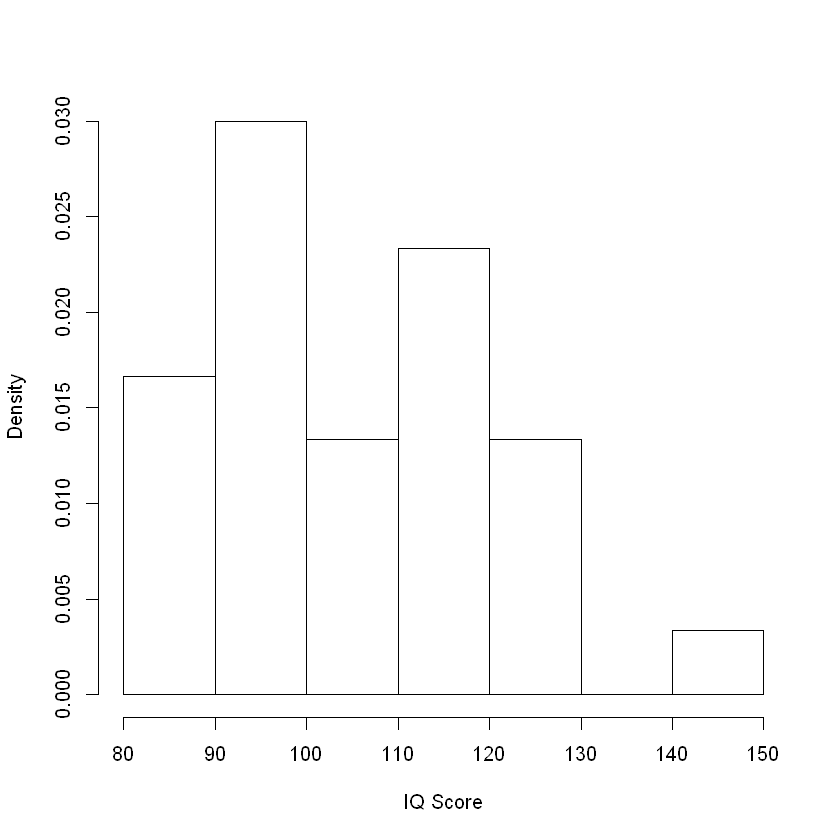

In [2]:
set.seed(12792) # ignore; here for reproducibility
iq.sample <- rnorm(30, mean = 108, sd = 15)
hist(iq.sample, probability = T, xlab = 'IQ Score', main = '')
observed.sample.mean <- mean(iq.sample)
print(paste("Sample Mean:", round(observed.sample.mean, 2)))

We said that we know apriori that the public's IQ scores are distributed Normally with mean 100 and standard deviation 15.  This same model serves as a good null hypothesis that taking 2+ AP exams is *not* associated with higher IQ scores, i.e. this group of kids has the same distribution as the overall public.  In math, we might write this as follows.
$$ H_0: \text{Normal}(100, 15)$$

This null model describes data on the individual level.  How does this translate to the statistic level?  In this case, we have decided that the statistic of interest is the sample mean.  Using simulation, I can generate a million size-30-datasets using the null model and calculate a sample mean for each one.  In a histogram, I'll plot this along with the sample statistic we actually observed.

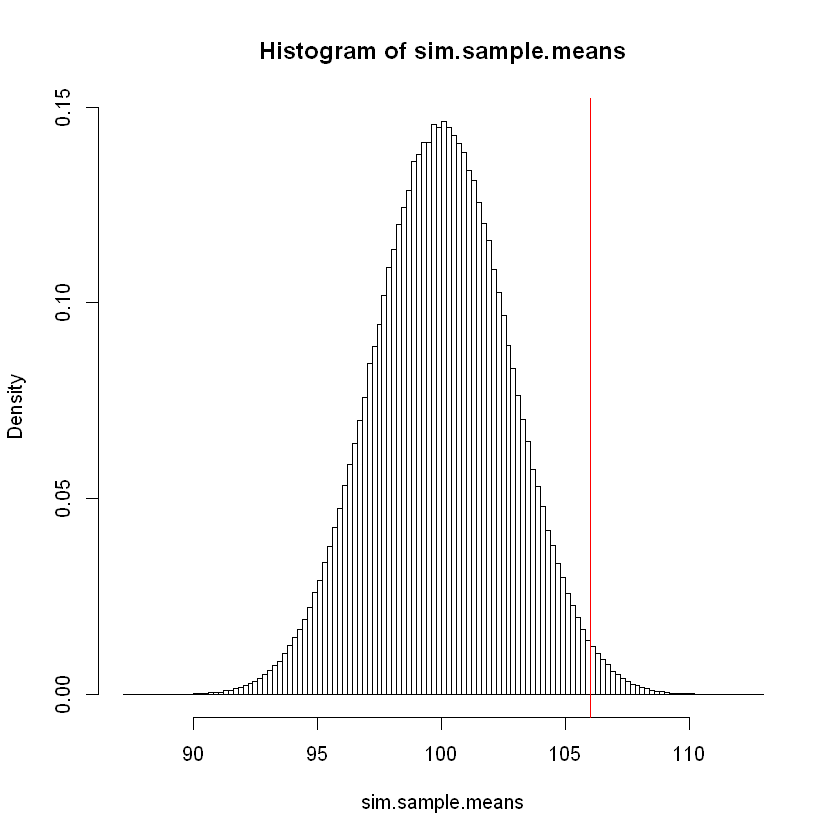

In [3]:
# you don't need to understand why below works
sim.sample.means <- rnorm(1000000, mean = 100, sd = 15/sqrt(30))
hist(sim.sample.means, prob = T, breaks = 100)
abline(v = observed.sample.mean, col = 'red')

What is your interpretation of the red line?  Does observing data at that location seem likely or not?  As we can see, it certainly is possible, but it's not very likely.  How can we formalize this?  The next question to ask is - if the null model is not true, what type of deviations would be scientifically interesting?  When this is turned into a claim about the distribution's parameter, this is known as an **alternative hypothesis**.  In this case, we are interested in detecting if the mean IQ score for these type of kids is higher than the overall public's.  Specifically, we are aiming to detect if their Normal distribution's mean parameter is greater than 100; this is the alternative hypothesis.  In math, we could write this as:
$$ H_1: \text{Normal}(\mu, 15) \\ \text{where } \mu > 100 $$

Notice that the alternative hypothesis actually encompasses an infinite number of possible probability models; however, the most important aspect is its direction relative to the null model. Using this, we can finally provide a quantitative answer.  First, we must calculate a p-value.  Operationally, this looks at the histogram above and determines how likely it was to observe a sample statistic that is equal to or *more extreme* than the value you actually observed.  The definition of more extreme is determined by the directionality of your alternative hypothesis.  In this case, it means "on the red line or more to the right".  Since we simulated a million data points, we can just look at the proportion that were greater than or equal to our observed sample statistic.

In [4]:
mean(sim.sample.means >= observed.sample.mean)

[1] 0.014011

We interpret this p-value as follows: under the null hypothesis/model, there is a 1.4% chance of observing a statistic as or more extreme than the one we actually observed.  If you need to make a binary decision, you can choose to *reject* the null hypothesis *in favor* of the alternative if your p-value is below some threshold such as 5%.  However, caution that this cutoff is entirely arbitrary and the p-value itself is much more informative.  In this particular case, we might then make the scientific conclusion that there is reasonable evidence that taking 2+ AP exams is associated with higher IQ scores.


If you choose to make a binary decision, there is always going to be some probability you make a mistake, but the definition of a mistake is always relative to what we assume is true.  The **Type-1** error rate corresponds to when the null hypothesis is true.  Our decision to reject the null hypothesis if the p-value is below some threshold such as 5% thus corresponds to something very specific - we are controlling the Type-1 error rate at 5%. You don't need to know this - but this is known as the Neyman-Pearson framework for hypothesis testing. We will discuss Type-2 error rates later today.

An interesting question to think about is why do we control the Type-I error rate at 5% when we reject p-values below 0.05?  What is the correspondance here?  The answer lies in p-values being uniformly distributed between 0 and 1 when the null hypothesis is true.  In this one-sided test, the p-value is simply 1 minus the percentile of the test statistic under the null distribution.  What is the distribution of a randomly chosen percentile?  Uniform!  Thus, only test statistics that fall in the 95-100th percentiles of the null distribution get rejected, and that happens with a 5% chance since p-values are uniformly distributed.  If you didn't get that - don't worry.  Just take away that when the null hypothesis is true, the p-value is simply a completely (i.e. uniformly) random number between 0 and 1.  

## Ex) Two-Sided Test for Difference in Means

We will do one more example where we use simulation to perform a hypothesis test.  There will be two main differences in this example:

- The null hypothesis will not be a single distribution.  Similarly to what we saw with our alternative hypothesis, our null hypothesis will be a **collection of probability models**.  The null hypothesis will consist of all probability models where the true means in two subgroups are equal. 

- In such problems, it is important to choose a **test statistic** that has the same distribution under every probability model in the null hypothesis.  For example, if we choose a difference in sample means as the test statistic, we don't actually need to know what the common mean is for a null probability model.  If the two groups share a common mean, then the difference between their sample means will always be centered at 0, regardless of what that common mean is.  This will be a common theme - every test we look at will have some fancy construction of a test statistic that mathematically ensures this property.

- We will consider a **two-sided** alternative hypothesis.  This means the definition of "extreme values" for our sample statistic corresponds to values in both the left and right tails of the distribution under the null hypothesis.  

Suppose that you wanted to compare white blood cell count (wbcc) between healthy individuals and those on glucocorticoids.  If you recall, these counts were approximately normally distributed when we log transformed them.  We set assume the standard deviation for each subpopulation to be the *same* and further assume that it's a known value from previous data, $\sigma = \sqrt{0.3}$.  Note that we make these unrealistic assumptions for pedagogical clarity of the procedure, and we will be allowed to be more flexible in future hypothesis tests that we explore.

Thus, we will model the distribution of log wbcc for healthy individuals as 

$$\text{Normal}(\mu_h, \sqrt{3}).$$

with $\mu_h$ as unknown.  Similarly, we model the distribution of log wbcc for individuals on glucocorticoids as

$$\text{Normal}(\mu_g, \sqrt{3}).$$

with $\mu_g$ as unknown.  Despite being unknown, our null hypothesis will make the claim that the two unknown parameters are equal:

$$ H_0: \mu_h = \mu_g $$

An important observation to make here is that under *any* probability model compatible with our null hypothesis, the distribution of the *difference* of sample means should be centered around 0.  Thus, this difference of sample means makes an ideal test statistic for this problem.

Our two-sided alternative hypothesis will encompass all other probability models within our scope.

$$ H_1: \mu_h \neq \mu_g$$

Say that we gathered the log wbcc for 24 healthy patients, but were only able to gather the log wbcc for 12 patients on glucocorticoids.  Let's pretend the data was given to us from nature, even though we'll simulate it ourselves.  I'll use concrete numbers for the simulation, but remember, in our analysis we never have access to these!

In [5]:
set.seed(243941811) # just here for reproducability
wbcc.healthy <- rnorm(24, mean = 2.3, sd = sqrt(0.3))
wbcc.gluco <- rnorm(12, mean = 2.8, sd = sqrt(0.3))
test.statistic <- mean(wbcc.gluco) - mean(wbcc.healthy)
round(test.statistic, 3)

[1] 0.587

Now let's get to simulating the distribution of the test statistic under the null hypothesis! Recall that we argued that the distribution is the same, regardless of whichever particular model is true in the null hypothesis. I'm going to appeal to some math and cheat a little bit; it turns our regardless of what the common mean is, the distribution of the difference in means will be 

$$\text{Normal}(0, \sqrt{0.3/24 + 0.3/12})$$

You don't need to know why that is, but we can use it to simulate and thus visualize the distribution.

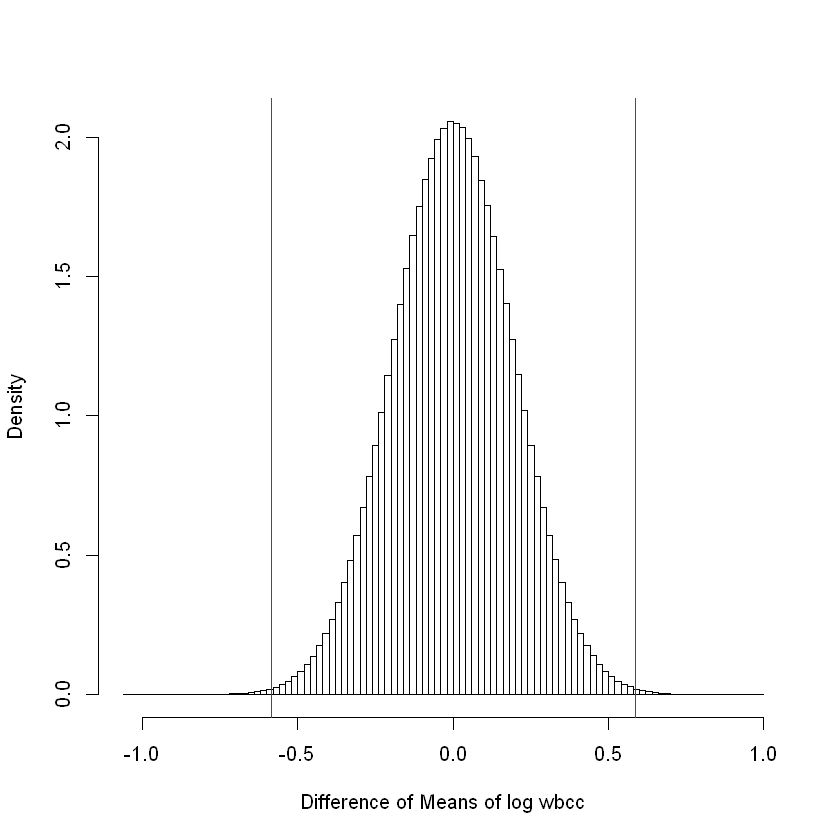

In [6]:
null.sd <- sqrt(0.3/24 + 0.3/12)
simulated.null.hypothesis <- rnorm(10000000, mean = 0, sd = null.sd)
hist(simulated.null.hypothesis, freq = F, main = "", xlab = "Difference of Means of log wbcc", breaks = 100)
abline(v = abs(test.statistic), col = 'red')
abline(v = -abs(test.statistic), col = 'red')

Recall, the above is a visualization of what the distribution of difference-of-means would have been if we gathered 10,000,000 datasets under this null hypothesis.  Recall that we observed a statistic of 0.587, i.e. our observed difference of means was 0.587 in our dataset.  Under our null hypothesis, "extreme" would mean seeing something greather than 0.587, but it would *also* mean seeing something less than -0.587.  Thus, our p-value can be approximated by

In [7]:
above <- simulated.null.hypothesis >= abs(test.statistic)
below <- simulated.null.hypothesis <= -abs(test.statistic)
pvalue <- mean(above | below)
round(pvalue, 5)

[1] 0.00244

Our p-value tells us that the data we saw or something more extreme had an extremely low chance of being generated by any of the probability models given to us by the null hypothesis.  Therefore with much higher probability, our data was generated by a probability model in accordance with the alternative hypothesis. 

Don't want to simulate?  Don't worry; you don't actually need to the majority of the time.  We just did for demonstration purposes.  We can actually use math to get many answers without simulation, though simulation can often times be a good fallback.  For example, our last hypothesis test gave us a p-value of $0.243\%$ via simulation.  However, we could have calculated the p-value *exactly* without using any simulated values in this situation:

In [8]:
lower.p <- pnorm(-abs(test.statistic), mean = 0, sd = null.sd, lower.tail = TRUE)
upper.p <- pnorm(abs(test.statistic), mean = 0, sd = null.sd, lower.tail = FALSE)
round(lower.p + upper.p, 5)

[1] 0.00244

You don't need to understand the code; just observe that it doesn't use the simulated values anywhere.

Oh no - does the thought of math give you an aneurysm?  Don't worry!  Someone else has done the math for you and wrapped it up in a function.  Let's repeat the previous analysis.  This time, we'll use a different test - one where we *don't* need to assume that we know the common variance apriori (but the two distributions under consideration must still be in the Normal family).  Same null hypothesis.  Same alternative.

In [9]:
result <- t.test(x = wbcc.healthy, y = wbcc.gluco, 
                 alternative = "two.sided", mu = 0, var.equal = TRUE)
round(result$p.value, 4)

[1] 0.0082

We got a very similar result as before!  Note that it wasn't exactly the same, since this is a different test.  Since we didn't assume that we knew the common variance apriori this time, we pay a slight price in uncertainty with our p-value (indicated by its slightly larger value).  This will be a common theme. Tests that make fewer assumption apply to more scenarios, but they require more evidence to reject null hypotheses.  For general intuition, suppose your alternative hypothesis is true.  Your p-value will be smaller if you 

- Choose a test with more stringent (but correct) assumptions
- Have a larger true effect size
- Have a larger sample

One quick clarification.  In our simulations, we looked at the distribution of easily interpetable statistics.  First, the sample mean IQ score.  Next, the sample mean difference of log wbcc.  In the hypothesis tests that follow, we will be using slightly less interpretable statistics.  These are usually transformations or combinations of interpretable quantities. They are constructed to ensure that the distribution of the test statistic under every probability model within the null hypothesis is the same and mathematically "nice".  They will take on names like the "t statistic" or the "rank sum statistic" or the "chi squared statistic".  The distribution of *these* statistics are what you should realize is being examined under the hood when you call your testing functions.  

## Assumptions

Someone needed to do some fancy math to write your testing function for you.  This fancy math relies on some probability model implied by your null hypothesis.  As we've already discussed, every test will have some *assumptions* that are made; these allow the probability model to be well-specified and for the math to go through.  If the assumptions are not met, then the result of the test will be *inaccurate*.  The level of inaccuracy will be related to how badly the assumptions are violated.  Remember how all models are wrong, but some are useful?  Your assumptions will almost always be violated to some small extent.  This should be viewed as acceptable.  But assumptions always need to be checked, and large violations will require you to approach your analysis with a different, more flexible test and possibly consult your local statistician.

An assumption that will be needed for every test that we cover is statistical independence of samples.  Suppose that every row in your dataset comes from a single patient.  Then independence of samples simply means that one patient's data isn't somehow influenced or "connected to" another patient's data (say from a mistrained nurse inappropriately measuring blood pressure in some subgroup of patients in the dataset).  An example where samples may *not* be independent is if subsequent rows contain subsequent measurements on the same patient.  The next measurement may indeed by influenced by the values of the previous measurement.

Another assumption that's needed is that the data from each sample is "identically distributed".  This simply means all your individual-level samples for a variable come from the same distribution; this is very basic assumption, which you shouldn't worry about.  However, I mention it for a reason.  In the literature, it is exceedingly common to package the previous two assumptions together in a phrase called the i.i.d. assumption, which stands for independently and identically distributed.  All the tests we look at today make the i.i.d. assumption.

Further assumptions that we may come across is that the data must be normally distributed or that the variances of two distributions must be the same.  You can almost never know this information *apriori*; they are assumptions we make.  There are formal ways of trying to check if these assumptions are close enough to true, but visualization goes a long way here.  

Another common assumption is that the sample size is "sufficienty large".  Common wisdom is this means more than 30 samples, but it's honestly quite dependent on the test you're using and the distribution of your data.  However, if you have at least 100-200 samples, you should almost always feel very safe.  If your number of samples needs to be "sufficienty large", then our inferential procedure will be relying on the Central Limit Theorem (CLT) that we saw last session.  Tests that rely on large samples and the CLT to make the math go through are known as **asymptotic tests**.  Tests that don't do this and work for all sample sizes are known as **exact tests**.

Assumptions will be a key part of both halves of inferential statistics: hypothesis testing and estimation (touched on in the next session).  Let's get into our hypothesis tests!

# Continuous-Continuous Tests
## Pearson Correlation Test

The Pearson Correlation Test provides a way to perform inference on your Pearson Correlation Coefficient between two paired, continuous variables.  This *exact* test **assumes** that both variables are normally distributed, but each variable is allowed to have its own mean and standard deviations.  There does exist a modified version of the test that works with non-normally distributed variables (through using a type of simulation), but we'll ignore this.

You may recall that Pearson Correlation Coefficient describes linear correlation in a sample.  The null hypothesis usually encompasses all probability models where the linear correlation is zero. A two-sided alternative that's commonly considered is all probability models where the linear correlation is non-zero.  Letting $\rho$ be the Pearson Correlation Coefficient, we equivalently can say

$$ H_0: \rho = 0 \\ H_1: \rho \neq 0$$

Let's look at two approximately normally distributed variables.  Let's visually verify that they are indeed approximately normal using QQ-plots with a Normal reference.

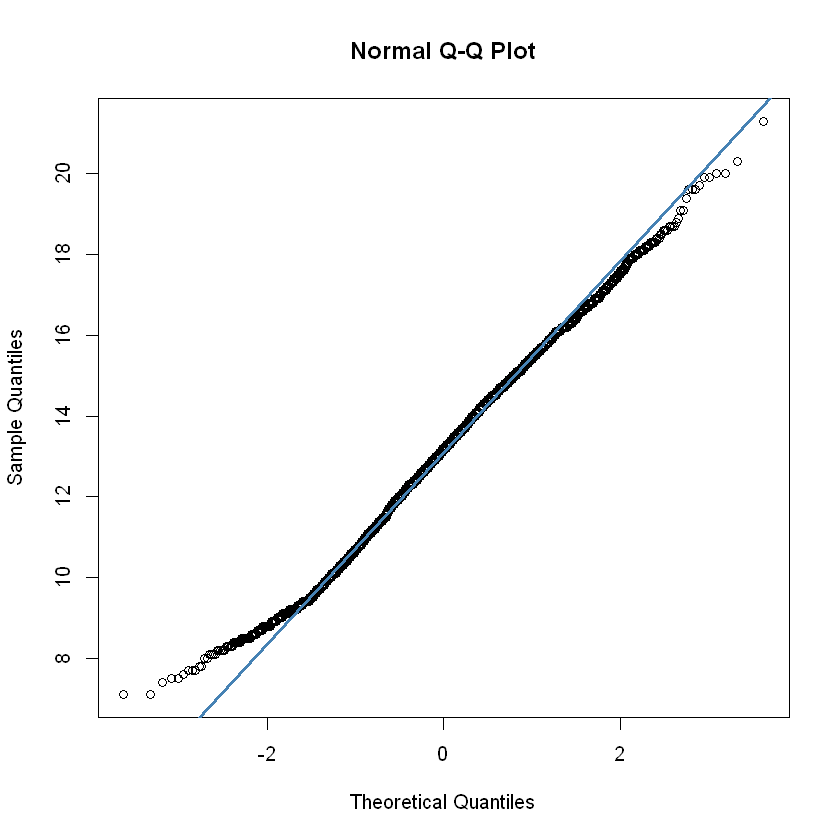

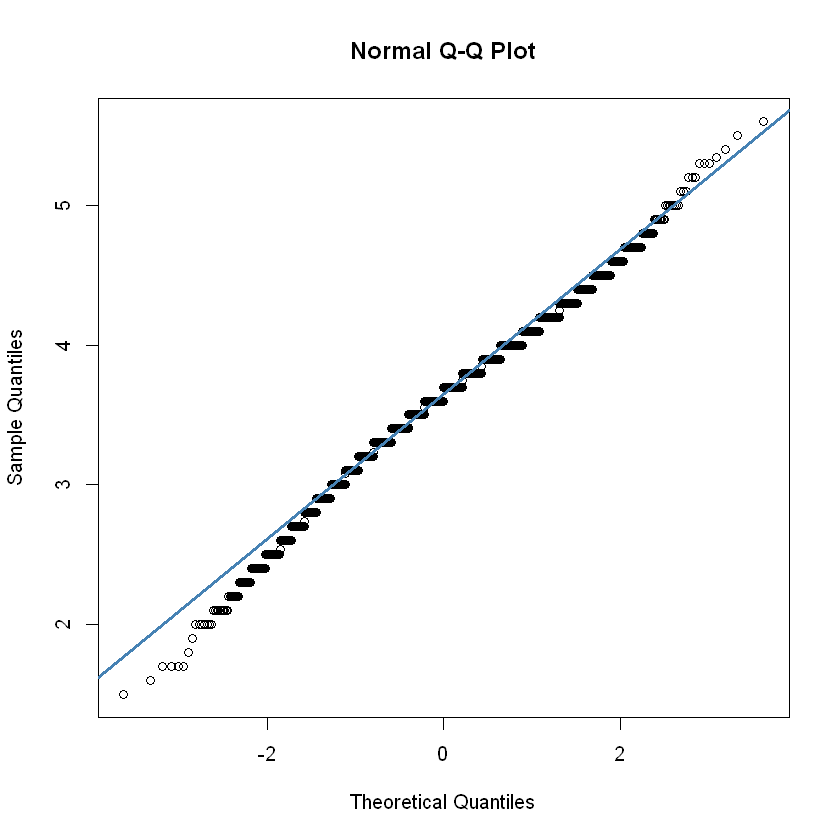

In [10]:
qqnorm(df$hemoglobin_max)
qqline(df$hemoglobin_max, col = "steelblue", lwd = 3)
qqnorm(df$albumin_max)
qqline(df$albumin_max, col = "steelblue", lwd = 3)

Eh, close enough.  Let's run the test.  The output is a named list with names such as "statistic" and "p-value" if you want to extract those elements.  However, someone's already coded up a nice display for us, and just printing the list will display that.

In [11]:
results <- cor.test(df$albumin_max, df$hemoglobin_max, 
                    alternative = "two.sided", method = "pearson")
print(results)


	Pearson's product-moment correlation

data:  df$albumin_max and df$hemoglobin_max
t = 15.358, df = 3414, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2225691 0.2853122
sample estimates:
      cor 
0.2542081 



And just to verify that the correlation aligns with our visual intuition:

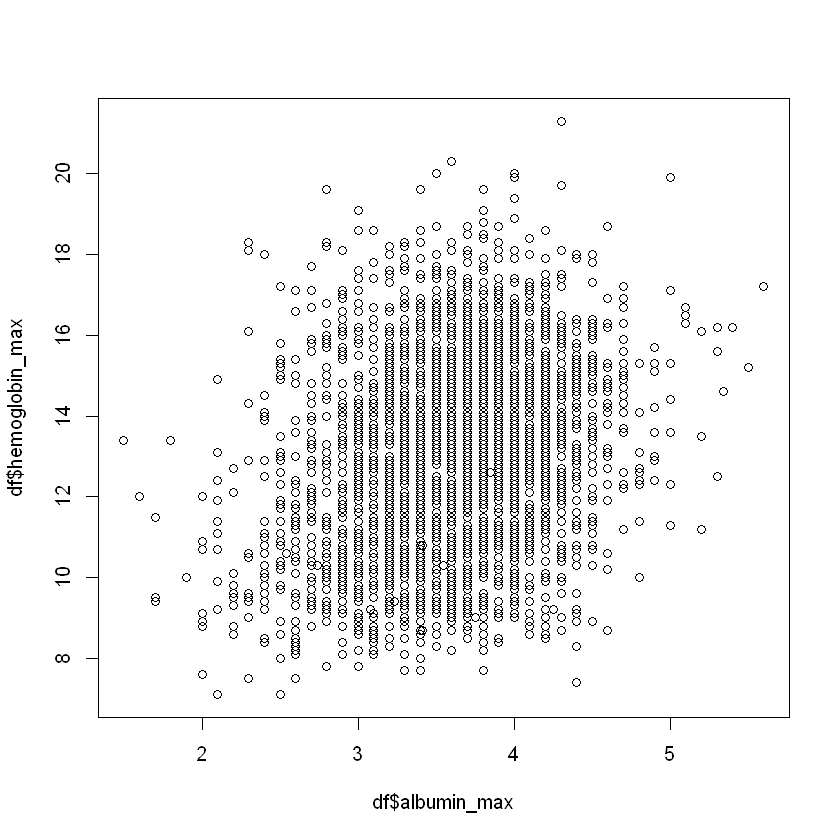

In [12]:
plot(df$albumin_max, df$hemoglobin_max)

## Spearman Correlation Test

The Spearman Correlation Test allows us to perform inference on the Spearman Correlation Coefficient.  Recall that it is not restricted to linear trends and tries to detect *any* purely increasing or purely decreasing trends in the data, which is called "monotonic".  There are no restrictions on the distributions on the variables, except for the fact that they have a natural orderering; all continuous data has this feature.  The price we pay for this flexibility is that this is an *asymptotic* test.

The way this test achieves its flexibility is by running the Pearson Correlation Test on the sample ranks of the data. Ranks are conceptually closely tied with the sample order statistics we saw earlier, and equivalent (up to a constant multiplicative factor) to the sample percentiles.  For example, a datapoint may fall at the 20th percentile with respect to one variable, but the 61st percentile with respect to another.  The Spearman correlation coefficient measures the linear relationship between these percentiles.  Let's first visualize the relationship between two continuous variables.

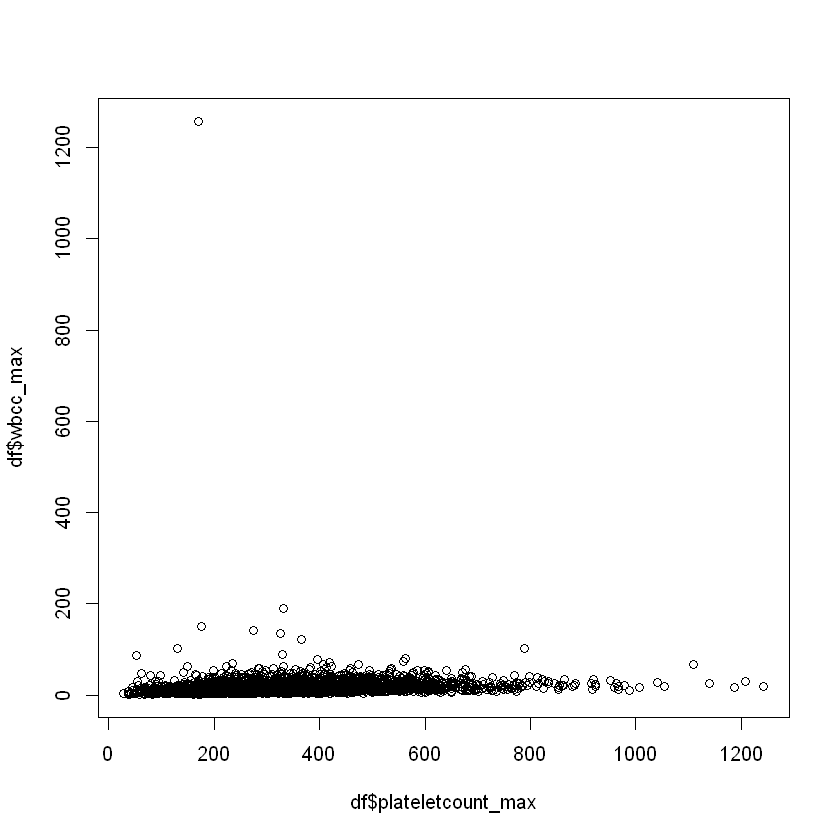

In [13]:
plot(df$plateletcount_max, df$wbcc_max)

Not super helpful.  Those outliers will have a disproportionally large influence on the Pearson Correlation Coefficient.  Let's look at this data converted into percentiles now.

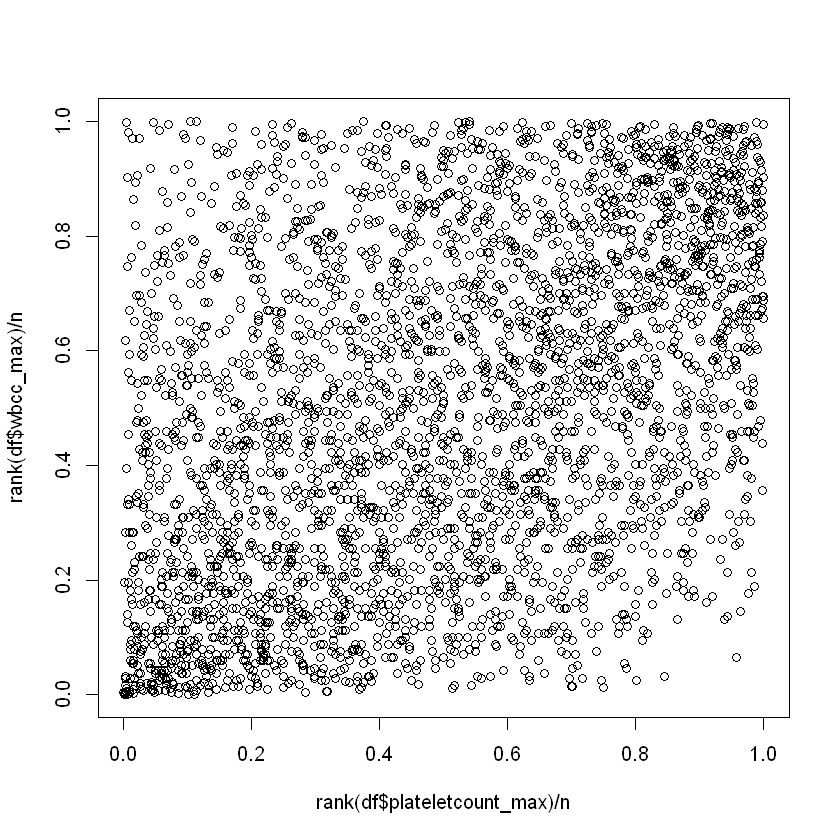

In [14]:
n <- nrow(df)
plot(rank(df$plateletcount_max)/n, rank(df$wbcc_max)/n) # quick way to get percentiles

The trend is much clearer to establish now.  Let's see what the formal test thinks about the full data.

In [15]:
cor.test(df$plateletcount_max, df$wbcc_max, 
         alternative = "two.sided", 
         method = "spearman", 
         exact = F)


	Spearman's rank correlation rho

data:  df$plateletcount_max and df$wbcc_max
S = 3861457176, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4187688 


An exact p-value cannot be calculated if there are multiple data points with the same exact value - only an approximate p-value can be constructed.  The setting "exact = FALSE" makes this explicit.  The default is "exact = TRUE", but if you try to use data with ties in the ranks, it will fire a warning and switch to "exact = FALSE".

When "exact = FALSE", R runs an "asymptotic test".  Recall that this just means that we must check that the sample size is sufficiently large for this test to be accurate.  Luckily, we have more than 3,000 samples, so it certainly is.

So what would you do if you had a small sample size AND had ties in your ranks?  Out of luck?  Not quite.  Talk to your local statistician!  There's almost always a way to get an accurate p-value, though the approaches might be a little non-standard.

## In-Class Exercise 1: Choosing Correlation Tests

1. Choose an appropriate correlation test to detect an association between sodium_min and bicarbonate_min. Your hypotheses are:
$$ H_0: \rho = 0 \\ H_1: \rho > 0 $$
This alternative hypothesis is specified by the argument "alternative = greater".  Justify your choice of test.  According to your results, does the null hypothesis have enough evidence to support it?

2. Choose an appropriate correlation test to detect an association between inr_min and ph_max. Your hypotheses are:
$$ H_0: \rho = 0 \\ H_1: \rho \neq 0 $$
This alternative hypothesis is specified by the argument "alternative = two.sided".  Justify your choice of test.  According to your results,  does the null hypothesis have enough evidence to support it?

**Solution:**

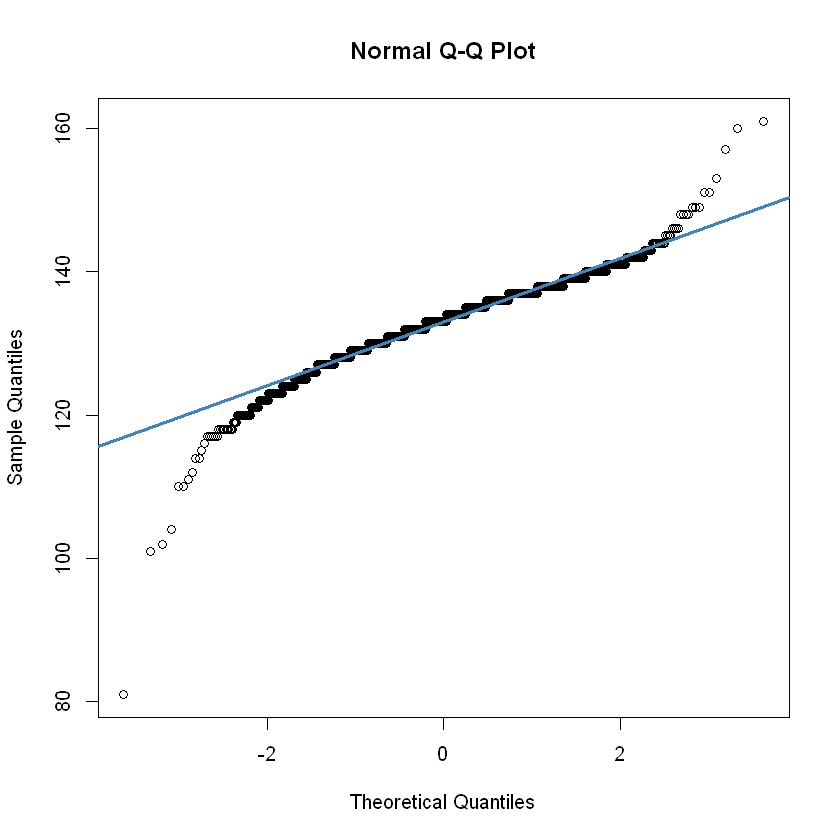

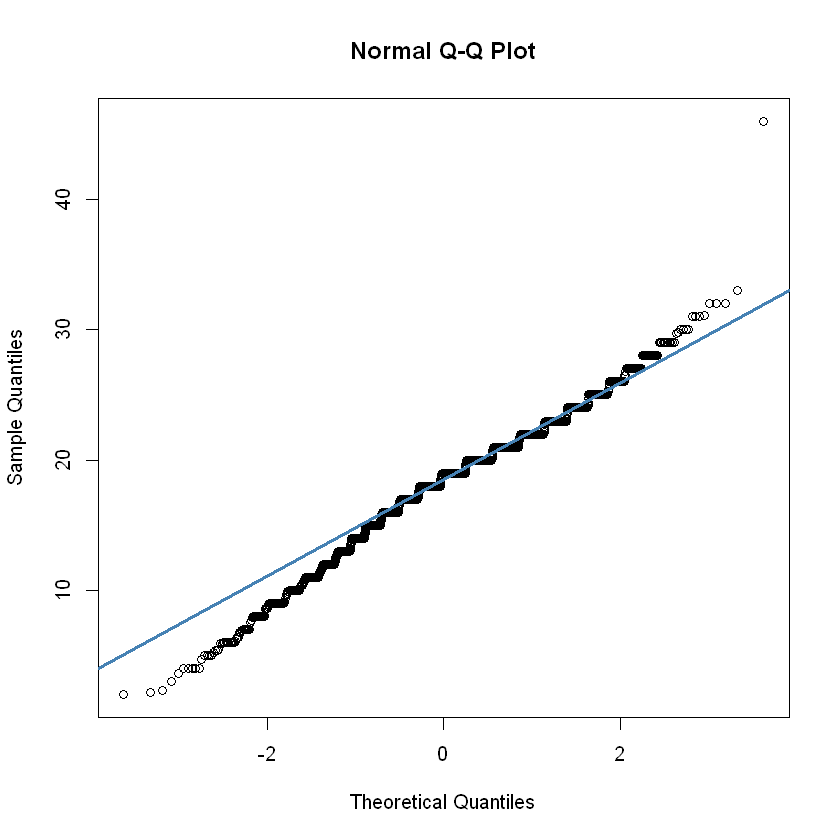

In [16]:
qqnorm(df$sodium_min)
qqline(df$sodium_min, col = "steelblue", lwd = 3)
qqnorm(df$bicarbonate_min)
qqline(df$bicarbonate_min, col = "steelblue", lwd = 3)

In [17]:
cor.test(df$sodium_min, df$bicarbonate_min, 
         alternative = "greater", 
         method = "pearson", 
         exact = F)


	Pearson's product-moment correlation

data:  df$sodium_min and df$bicarbonate_min
t = 16.32, df = 3414, p-value < 2.2e-16
alternative hypothesis: true correlation is greater than 0
95 percent confidence interval:
 0.2427121 1.0000000
sample estimates:
     cor 
0.269022 


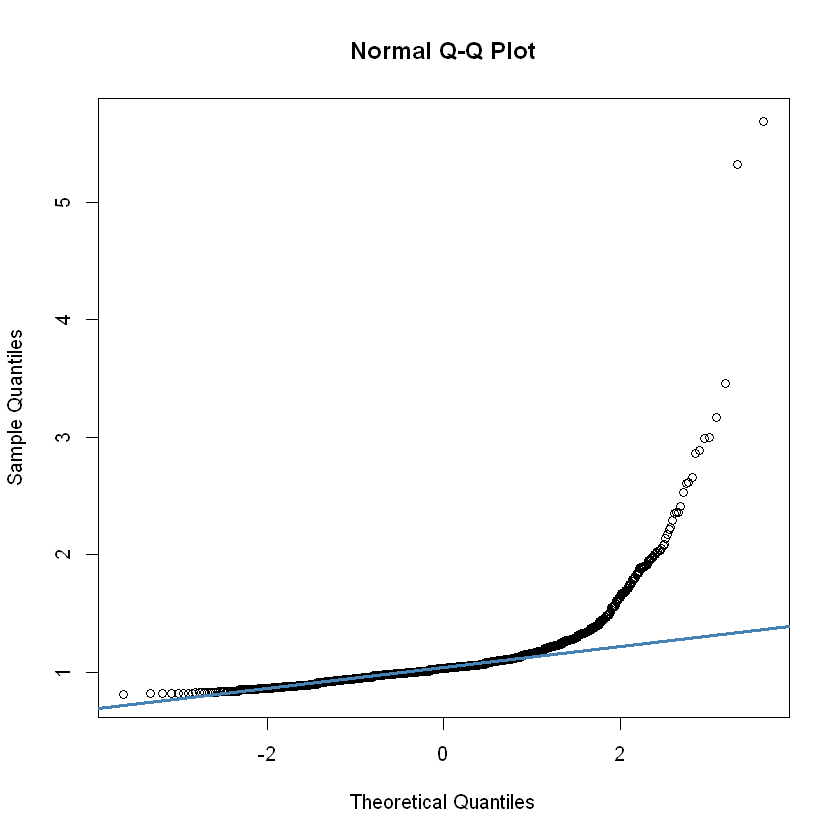

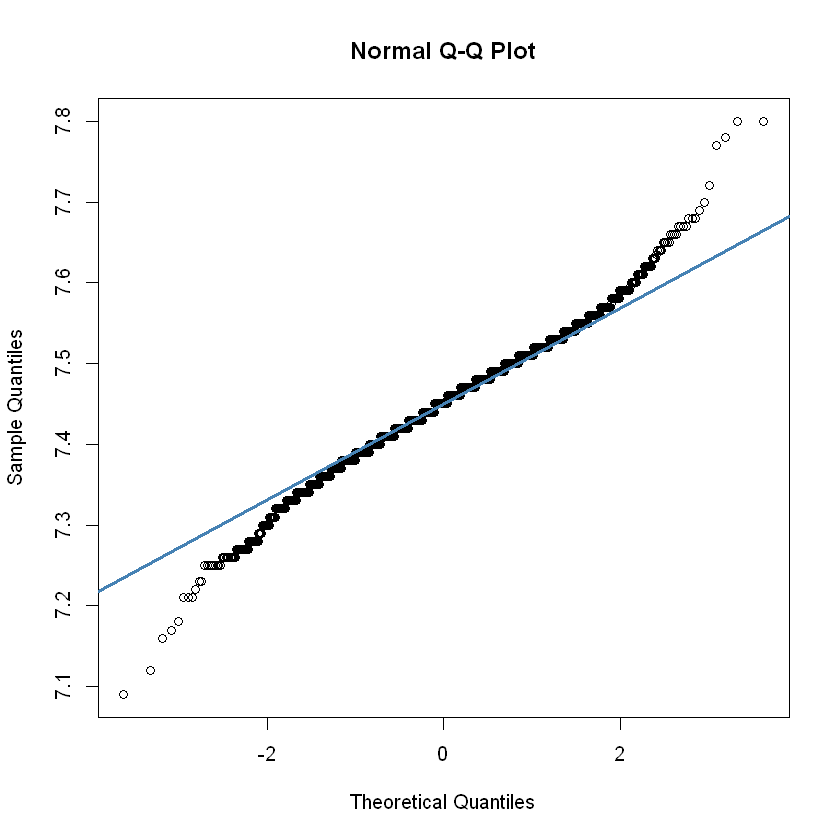

In [18]:
qqnorm(df$inr_min)
qqline(df$inr_min, col = "steelblue", lwd = 3)
qqnorm(df$ph_max)
qqline(df$ph_max, col = "steelblue", lwd = 3)

In [19]:
cor.test(df$inr_min, df$ph_max, 
         alternative = "two.sided", 
         method = "spearman", 
         exact = F)


	Spearman's rank correlation rho

data:  df$inr_min and df$ph_max
S = 6699945669, p-value = 0.6201
alternative hypothesis: true rho is not equal to 0
sample estimates:
         rho 
-0.008483931 


# Continuous-Discrete Tests

## t-Test
We saw this test a little earlier!  Let's be a bit more formal about it.  The t-test is there to establish whether there is a difference in mean between two collections of continuous data.  There are actually 4 versions of the t-test based on the conditions of whether the "design is paired" or not and whether we assume "homogeneity of variances" or not.  They all use a test statistic that is a difference of two means that has been standardized in some way; this test statistic follows a "t Distribution" under the null hypothesis, which is where this test gets its name.  In all cases, the t-test is an exact test that **assumes** that the two variables being compared each come from the Normal family of distributions.

Let's look at the "design" condition, which really just clarifies why we are using a t-Test.

 - Paired design: The first use of a t-test is for comparing the difference in sample means between two, paired continuous variables.  For example, suppose that in each patient you measured something before and after a procedure.  This is considered a paired design, since each patient has 2 possible correlated measurements.  

- Unpaired design: The second use of a t-test is for comparing the difference in sample means between a single continuous variable subset across 2 groups.  In this case, the normality assumption of the test corresponds to each subgroup of the continuous variable being normally distributed.  As an example, height might not be normally distributed overall, but it is approximately Normal within the male subgroup and also within the female subgroup.  This is an unpaired design, since there would be no natural way of pairing individuals between the male and female subgroups. This case will be our primary focus. 

Next, we look at the "homogeneity of variances" condition.

- Assumed homogeneity: Here, we **assume** the standard deviation of these normal distributions are the same or not.  If you have reason to believe you can make this assumption, you should, because then you would be able to get an accurate result with less data.  When this assumptuon is made in an unpaired design, it is known as **Student's t-test**.

- No assumed homogeneity: In general, we do not have information of the standard deviation a priori, so we typically do not make the assumption.  When this assumption is not made in an unpaired design, it is known as **Welch's t-test**.

Let's perform Welch's t-test.  We'll use the log of wbcc_max as our continuous variable. We'll subset on sex to form 2 groups and aim to compare the means between them.  Let's visualize if they are approximately normally distributed.

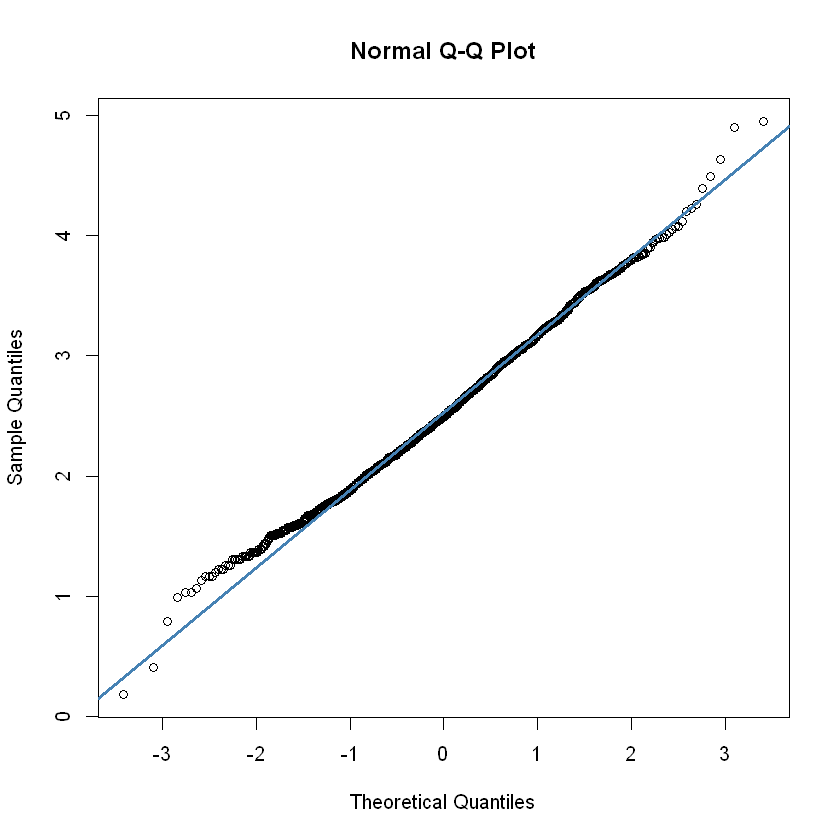

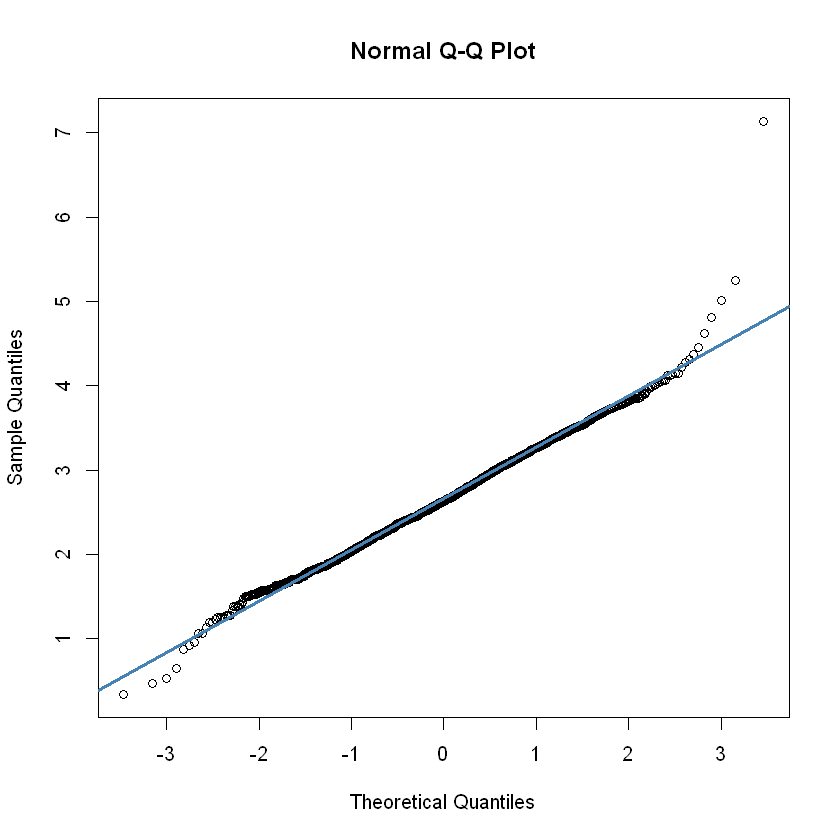

In [20]:
x.fem <- log(df$wbcc_max)[df$femalesex == 1]
x.male <- log(df$wbcc_max)[df$femalesex == 0]
qqnorm(x.fem)
qqline(x.fem, col = "steelblue", lwd = 3)
qqnorm(x.male)
qqline(x.male, col = "steelblue", lwd = 3)

Looks like they're both approximately normally distributed when split across sex.

Let's carefully examine the hypotheses we want to test now and their assumptions.  To begin with, we assume that, within each subgroup, the continuous variable has some Normal distribution.  Our null hypothesis will restrict each subgroup's mean to be the same.  We'll use a two-sided alternative hypothesis, which says that they are different. If $\mu$ represents a mean, this is equivalent to
$$ H_0: \mu_m = \mu_f  \\ H_1: \mu_m \neq \mu_f$$

The defaults for the **t.test** function are for Welch's t-test.  However, there are arguments to specify both the paired and homogeneity of variance settings if you want to change to a different test.  The t.test function uses the formula design pattern, which we will now show you can incorporate transformations *within* the formula.  We will use the default settings and perform a a two-sided Welch's t-test.

In [21]:
t.test(log(wbcc_max) ~ femalesex, 
       data = df,
       alternative = "two.sided")


	Welch Two Sample t-test

data:  log(wbcc_max) by femalesex
t = 5.6844, df = 3254.7, p-value = 1.429e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.0791863 0.1625773
sample estimates:
mean in group 0 mean in group 1 
       2.651617        2.530735 


We have a lot of data, so Welch's t-test was able to confidently tease out that these are different normal distributions, despite the difference in their means being so small.

One final interesting - we needed to make assumptions about the Normality of our data, which is fairly strict.  Partly due to the Central Limit Theorem I discussed last session, it turns out that when you have a large amount of data, t-tests work correctly with almost any shape your data has.  In other words, a t-test without Normality assumptions is an *asymptotic test*.  The asymptotic version of Welch's t-test is effectively identical to an asymptotic two-sample **Z-test**, which is another test you may come across.

## One-Way ANOVA

ANOVA stands for analysis of variance.  I wouldn't worry too much about what this means; just treat it like another test.  There is a one-way and a two-way version of this test, but we'll only focus on the one-way version in this class.  Think of One-way ANOVA as the analog of an unpaired t-test with homogeneity of variances (same variances), but extended to more than 2 groups. 

As a reminder, your **assumptions** for an exact test should be that the continuous variable within each group has a normal distribution and that their variances are all the same.  However, for similar reasons as the t-test, if you have a lot of data, ANOVA can be fairly robust to violations of these assumptions and act as an asymptotic test.

Let's look for an association between log wbcc_max and race this time.  Since we've discussed the robustness of the t-test and ANOVA, instead of constructing many QQ-plots, we'll just make do with a cruder visualization of their shapes using a boxplot.

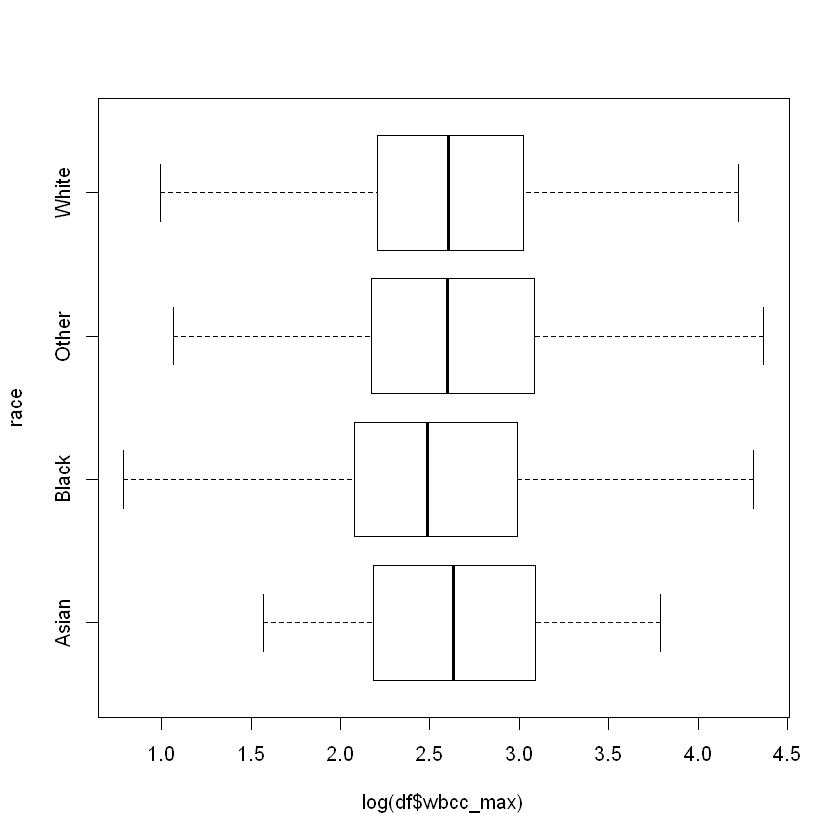

In [22]:
boxplot(log(df$wbcc_max) ~ race, data = df, outline = F, horizontal = T)

This looks pretty approximately normal to me, and the boxes are of similar width indicating approximately similar standard deviation.  The shorter whiskers for Asians is an artifact of only a small number of Asians being in the dataset.

The "F value" is the test statistic here.  The null hypothesis will be that all groups have the same mean.  The alternative hypothesis will be the two-sided alternative that *any* group has a different mean.  The **aov** function makes use of the formula design pattern that we've seen earlier.  Note that compared to the t.test function, to get a nice display, we must call the summary function on the results.

In [23]:
summary(aov(log(df$wbcc_max) ~ race, data = df))

              Df Sum Sq Mean Sq F value  Pr(>F)   
race           3    4.5  1.5145   3.953 0.00795 **
Residuals   3412 1307.3  0.3831                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

From this p-value, we can see that the null hypothesis is not supported, which shouldn't be surprising given our sample size.  However, this doesn't tell us which groups are different.  You can use a different test post-hoc to give you information on group-wise comparisons.  

In [24]:
TukeyHSD(aov(log(df$wbcc_max) ~ race, data = df))

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = log(df$wbcc_max) ~ race, data = df)

$race
                   diff         lwr        upr     p adj
Black-Asian -0.12833230 -0.33149968 0.07483509 0.3653912
Other-Asian -0.03057332 -0.23973286 0.17858622 0.9819254
White-Asian -0.05334818 -0.25236157 0.14566522 0.9013341
Other-Black  0.09775898  0.00652794 0.18899001 0.0301339
White-Black  0.07498412  0.01031790 0.13965034 0.0153593
White-Other -0.02277486 -0.10433738 0.05878767 0.8900916


From this, we can see that there are significant differences between Black vs Other and Black vs White.  However, despite the biggest effect size, the difference between Black vs Asian is not signficant due to the Asian sample size being so small.

## Wilcoxon Rank-Sum Test

This is an asymptotic test; it is also referred to as the Mann-Whitney U test.  This is a very flexible test for unpaired designs that works for comparing two distributions, regardless of their shape.  Like the Spearman Correlation Coefficient, it works with the percentiles of the data to achieve this flexibility.

In the most general formulation, the null and alternative hypotheses are a little abstract.  The null hypothesis is that neither distribution "stochastically dominates" the other, and the two-sided alternative states that one distribution does dominate.  What does it mean to "stochastically dominate"?  It is simply fancy language for one distribution tending to have slightly larger values than another.  Think of two overlaid histograms, where one has slightly more overall mass to the right.  In other words, it means - if I picked a random value from variable A and another random value from variable B, my value from variable A would be larger than my value from variable B more often than not.  

However, if we make an additional assumption, we can actually improve the interpretation of our hypotheses.  If we **assume** the two distributions have the same dispersion and shape, and they only differ in their location/center, then our hypotheses are the following.  The null states that the distribution's locations/centers are the same.  The two-sided alternative states that the locations are not the same.  You should visually check your data to see if you can assume this.  You are free to choose any measure of location in your interpretation.  The most common choice of location to use for non-normally distributed data is the median.  So in this case, your null is that the medians are the same, and the alternative is that they are not.

Let's do a short demonstration for why we need this additional assumption.  For two distributions with very different shapes, it is entirely possible for them to have the same median, yet the rank-sum test produces a very small p-value.  We will create y1 and y2 from distributions with very different shapes, but both are constructed to have a median of 0. 

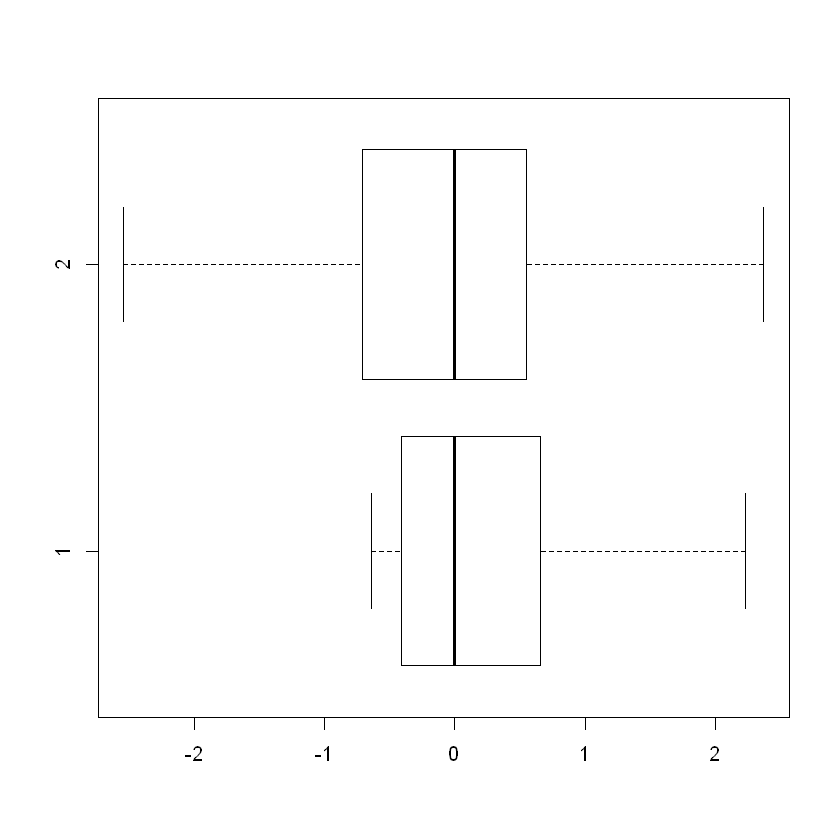

In [25]:
y1 <- rexp(500)
y1 <- y1 - median(y1) # centers median at 0
y2 <- rnorm(500)
y2 <- y2 - median(y2) # centers median at 0
boxplot(y1, y2, outline = F, horizontal = T)

In [26]:
wilcox.test(y1,y2)


	Wilcoxon rank sum test with continuity correction

data:  y1 and y2
W = 140060, p-value = 0.0009747
alternative hypothesis: true location shift is not equal to 0


As you can see, the p-value is very low, despite the medians being exactly the same.  So if you want to make your hypotheses about medians, you should ensure your data look similar in shape and scale, and only shifted in their center/location. 

Let's look at some real data.  We'll look again at white blood cell count, but now without the log transformation, since we don't need it here.  We'll look at two visualizations.  The QQ-plot between the subgroups will establish if they have a similar shape.  Then a boxplot can help us see if they have similar variability.

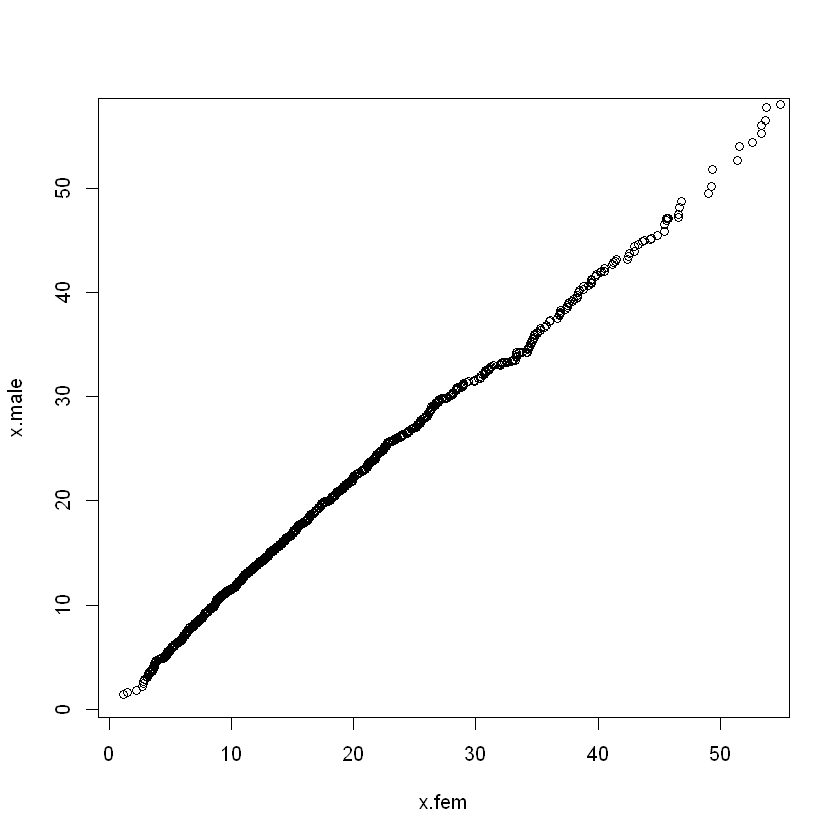

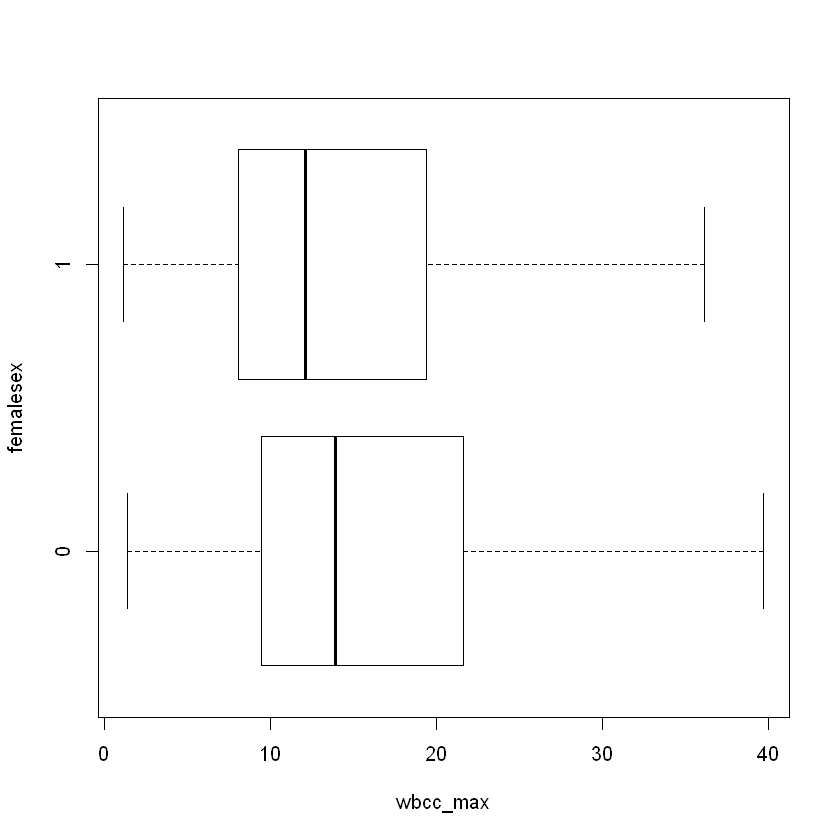

In [27]:
x.fem <- df$wbcc_max[df$femalesex==1]
x.male <- df$wbcc_max[df$femalesex==0]
qqplot(x.fem, x.male, 
       xlim = quantile(x.fem, c(0,0.99)),
       ylim = quantile(x.male, c(0,0.99)))
boxplot(wbcc_max ~ femalesex, data = df, outline = F, horizontal = T)

We will consider it good enough and assume that the two distributions do indeed approximately have the same shape and dispersion/variation and only differ in location.  Thus, the null hypothesis will be that the medians are the same.  And a two-sided alternative will be that they are different.

In [28]:
wilcox.test(wbcc_max ~ femalesex, 
            data = df, 
            alternative = "two.sided",
            exact = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  wbcc_max by femalesex
W = 1613864, p-value = 3.817e-09
alternative hypothesis: true location shift is not equal to 0


We use the formula pattern above, but you can do it both ways.  As with the Spearman test, we explicitly set "exact = FALSE" for clarity, since an exact p-value is not possible with ties in the data values.  Again, when "exact = FALSE", we use an asymptotic test, but our sample size is large so this is still extremely accurate.

Of note, just like the t-test, there is a paired design version for this test, which can be specified with the argument "paired = TRUE".  This test is named the Wilcoxon signed rank test, which you can read about on your own.  However, note that the assumptions needed for that test are slightly different and more restrictive than what we've shown here.

## Kruskal-Wallis Test
As the rank-sum test was a distributionally-flexible alternative to the t-test, the Kruskal-Wallis test is a distributionally-flexible alternative to ANOVA that relies on comparing percentiles/ranks of the data across a 3 or more groups.  Again, asymptotic test.

As with the rank-sum test, the null hypothesis states that no group stochastically dominates another, and the alternative is the two sided claim that at least one group stochastically dominates another.  Remember, think of a 3+ overlaid histograms with at least one histogram overall having a little more mass to the right or left than the rest.  However, like the rank-sum test, if we make **assumptions** about the shape and dispersion being the same for the distribution of each group, then we may interpret the hypotheses as claims about medians.  We will just use the boxplot visualization to crudely check the assumption.

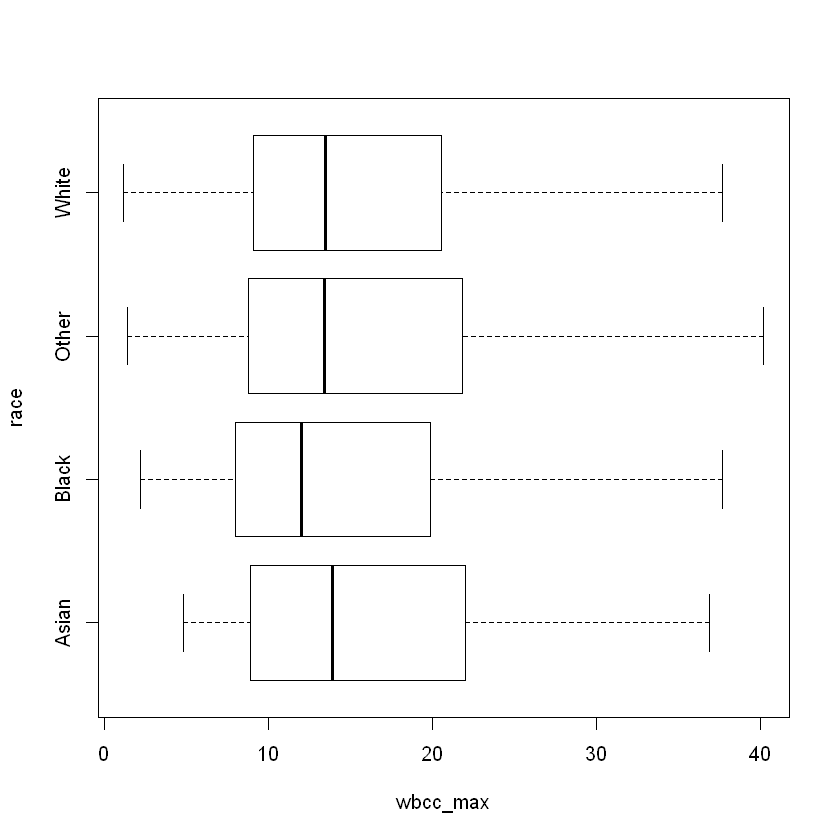

In [29]:
boxplot(wbcc_max ~ race, data = df, outline = F, horizontal = T)

Again, we'll treat this as good enough to make the assumption and use medians in our interpretation.

In [30]:
kruskal.test(wbcc_max ~ race, data = df)


	Kruskal-Wallis rank sum test

data:  wbcc_max by race
Kruskal-Wallis chi-squared = 11.784, df = 3, p-value = 0.008161


From our p-value, we know that at least one race's median significantly differs from the others, most likely "Black" from visualization and our results from ANOVA.

Lastly, note that this is also an asymptotic test, so you should make sure your sample size is sufficient within each group.  Although the number of Asians is relatively much smaller, 66 should be sufficient for this test.

## Syntax for Correct Direction

A quick note - when using the formula design pattern, R has this annoying habit of treating the "0" group as the first group and the "1" group as the second group for the discrete variable.  For example, if you ran a t-test, it would be testing for if the difference in means between those with no-pressors and those on pressors is signficiant.  Scientifically, we would typically think of this problem in the reverse direction - mean of those on pressors minus those without pressors.  

For a two-sided hypothesis test, this actually doesn't make a difference for the p-value, but affects other parts of the output.  However, for one-sided tests this does make a difference for the p-value as well.  Let's pretend our continuous variable is bicarbonate_max and the alternative is that the mean for those on pressors is greater than the mean not on pressors.   Here are 4 workarounds (dropping some arguments for simplicity).

In [31]:
t.test(bicarbonate_max ~ pressor, data = df, alternative = "less")
t.test(bicarbonate_max ~ (pressor==0), data = df, alternative = "greater")
t.test(bicarbonate_max ~ factor(pressor, levels = c(1,0)), data = df, alternative = "greater")
t.test(df$bicarbonate_max[df$pressor == 1], df$bicarbonate_max[df$pressor == 0], alternative = "greater")


	Welch Two Sample t-test

data:  bicarbonate_max by pressor
t = -17.664, df = 1861.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -3.477547
sample estimates:
mean in group 0 mean in group 1 
       28.21940        32.05421 



	Welch Two Sample t-test

data:  bicarbonate_max by pressor == 0
t = 17.664, df = 1861.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 3.477547      Inf
sample estimates:
mean in group FALSE  mean in group TRUE 
           32.05421            28.21940 



	Welch Two Sample t-test

data:  bicarbonate_max by factor(pressor, levels = c(1, 0))
t = 17.664, df = 1861.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 3.477547      Inf
sample estimates:
mean in group 1 mean in group 0 
       32.05421        28.21940 



	Welch Two Sample t-test

data:  df$bicarbonate_max[df$pressor == 1] and df$bicarbonate_max[df$pressor == 0]
t = 17.664, df = 1861.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 3.477547      Inf
sample estimates:
mean of x mean of y 
 32.05421  28.21940 


As you can see, the p-value for each approach is the same.  In order, these approaches

1. Calculated the p-value from the opposite tail that we want, since we know the test statistic will be negative of what we want it to be.
2. Transformed pressor so that "on pressor" corresponds to FALSE, which will be read as the first group.
3. Recoded the ordering of the levels of pressor so R reads "1" as the first group.
4. Used the alternative design pattern for the test function where you put in each vector manually; this lets us choose the correct group to be first.

The 3rd and 4th methods "feel" the most correct to me, but honestly the 1st is probably the fastest.

## In-Class Exercise 2: Comparing Location Tests

Both questions will examine the association between the variables creatinine_min and steroid.  They will use the following hypotheses where $d$ represents a difference in means or medians in questions 1 and 2, respectively:
$$ H_0: d = 0 \\ H_1: d \neq 0$$

1. Perform an unpaired t-test without assuming homogeneity of variances.  Are the Normality assumptions approximately satisfied for this test?  I have used some fancy statistics to approximate the true null distribution of the t-statistic when no assumptions are made - I got a p-value of 0.092660.  How close is this to what the t-test told you?  Why do you think there's similarity or discrepancy?  

2. Perform a rank-sum test.  Are the assumptions approximately satisfied to interpret this as a test about medians?   I have used some fancy statistics to approximate the true null distribution of a *different* test statistic that targets the median when no assumptions are made - I got p-value of 0.03827.  How close is this to what the rank-sum test told you?  Why do you think there might be similarity or discrepancy? 

**Solution:**


	Welch Two Sample t-test

data:  creatinine_min by factor(steroid, levels = c(1, 0))
t = -1.6903, df = 1967.6, p-value = 0.09114
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.16205180  0.01202295
sample estimates:
mean in group 1 mean in group 0 
       1.063822        1.138836 


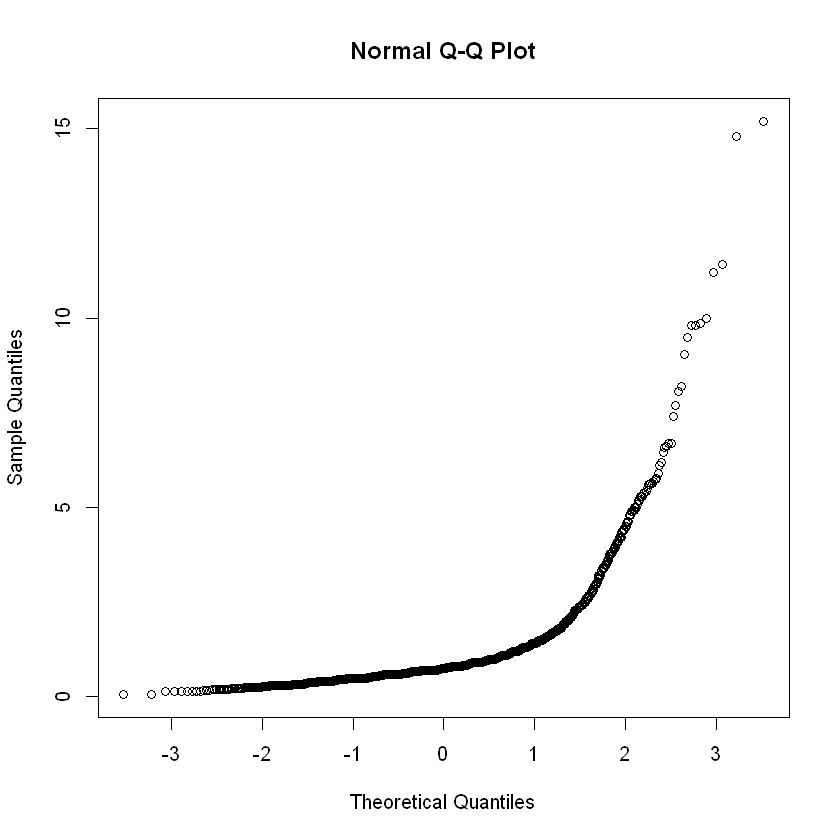

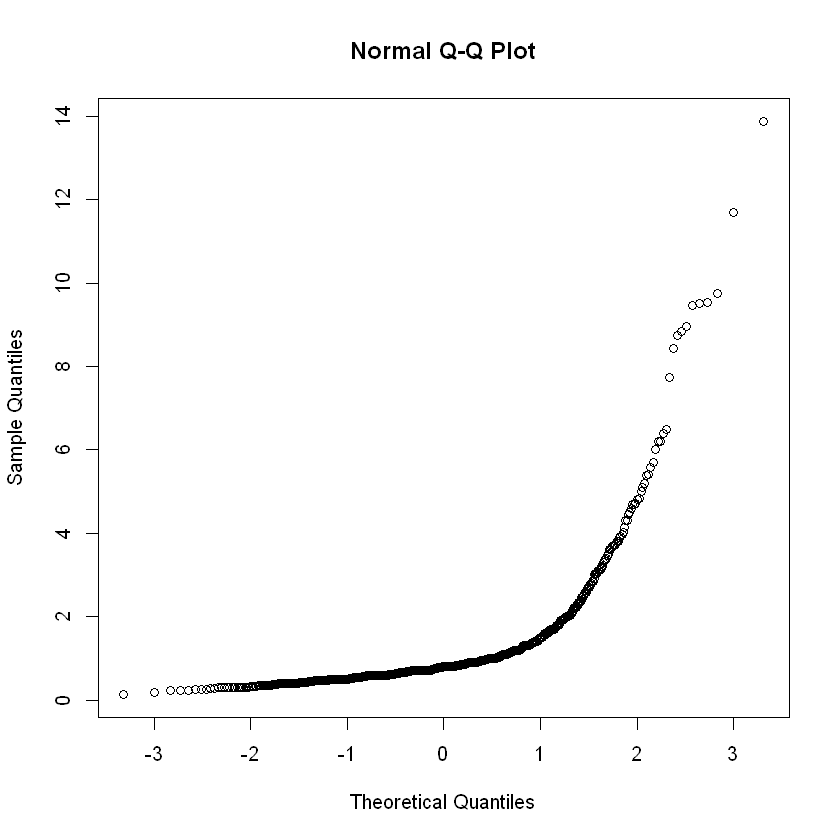

In [32]:
t.test(creatinine_min ~ factor(steroid, levels = c(1,0)), 
       data = df, 
       alternative = "two.sided")

cre.st <- df$creatinine_min[df$steroid == 1]
cre.no <- df$creatinine_min[df$steroid == 0]
qqnorm(cre.st)
qqnorm(cre.no)

The normality assumptions are clearly heavily violated, yet we still observe very little discrepancy with the true p-value.  Since our data size is fairly large for this type of problem, the t-test without normality assumptions works well as a correct asymptotic test, which explains the similarity of p-values.


	Wilcoxon rank sum test with continuity correction

data:  creatinine_min by factor(steroid, levels = c(1, 0))
W = 1203506, p-value = 0.0159
alternative hypothesis: true location shift is not equal to 0


[1] -0.1085364

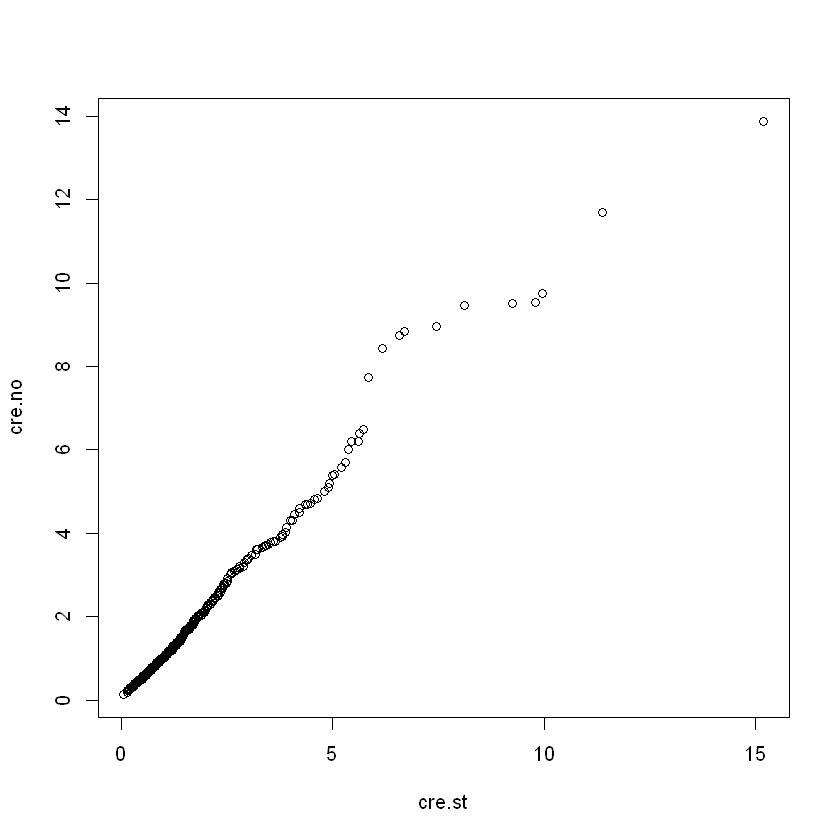

In [33]:
wilcox.test(creatinine_min ~ factor(steroid, levels = c(1,0)),
            data = df,
            alternative = "two.sided", 
            exact = FALSE)
qqplot(cre.st, cre.no)
sd(cre.st) - sd(cre.no)

The two distributions have fairly similar shapes according to the QQ-plot.  Their variability is also close (but not perfect) by the difference of their standard deviations.  I would call this a good enough match for the assumptions to treat this as a difference of medians.  However, there is a small discrepancy in comparison to the true p-value from the other test that directly targets the median.  There are 2 reasons.  

First, we do indeed have slight violations of the assumption, so the rank-sum test could be picking up on these other differences in distribution apart from location.  Secondly and more importantly, different tests have different sensitivities for detecting effects at the same sample size.  Let's reason through one of the primary reasons we see this.

Recall that the rank-sum test under the assumptions we talked about *is* a test of medians.  We saw that our assumptions are very close to being accurate.  So we are comparing two tests of medians - one that makes (nearly) correct assumptions and one that makes no assumptions.  Making correct assumptions restricts the space of probability models under consideration, and thus usually ends up lowering the variability of the null distribution; you can think of this as fewer "degrees of freedom" for the sample to vary in the infinite datasets experiment.  The lower the variability of the null distribution, the more extreme your test statistic will seem in comparison, no matter what it actually is.  A more extreme test statistic leads to a smaller p-value.  A smaller (but correctly constructed) p-value == more sensitive test.

# Discrete-Discrete Tests

## Chi-Squared Test for Independence

A chi-squared test for independence makes the obvious null hypothesis that two, paired categorical variables are statistically independent from each other.  This means that the status for one categorical variable has no bearing on the probability of another categorical variable.  This is a bit different than the null and alternative hypotheses that we've been looking at, but are roughly analogous in the sense that the null is "no relationship" and the alternative is akin to the two-sided tests we looked at in that they detect "some relationship".  The chi-squared test will be an *asymptotic* test.

Let's look at two markers for drug administration.  

In [34]:
observed.probs <- prop.table(table(df$arb, df$betablocker, dnn = c("arb", "betablocker")))
observed.probs

   betablocker
arb          0          1
  0 0.45901639 0.41920375
  1 0.03951991 0.08225995

Most hypothesis tests with discrete-discrete data form test statistics directly from the contingency table (or equivalently, its proportions form like above).  As a demonstration, we will actually construct the **Pearson chi-squared test** statistic manually.  From our knowledge of probability models, we can argue the following from the null hypothesis.  If these variables are independent, then as each patient gets admitted, nature flips a weighted coin to determine arb administration and then independently flips another weighted coin to determine betablocker administration.  The probabilities associated with these biased coins are approximately

In [35]:
p.arb <- mean(df$arb)
p.beta <- mean(df$betablocker)
round(p.arb, 3)
round(p.beta, 3)

[1] 0.122

[1] 0.501

Thus under this null hypothesis, I would expect the probabilities for each cell to look like the probabilities corresponding to each row and column to be multiplied together:

In [36]:
null.probs.row.1 <- c( (1-p.arb)*(1-p.beta), (1-p.arb)*p.beta )
null.probs.row.2 <- c( p.arb*(1-p.beta), p.arb*p.beta )
null.probs <- unname(as.table(rbind(null.probs.row.1, null.probs.row.2))) # turn rows into table
null.probs

     [,1]       [,2]      
[1,] 0.43782462 0.44039552
[2,] 0.06071168 0.06106818

Compare this to the table above.  Recall that to perform a hypothesis test, you need to generate a statistic (single number summary) from your data, which in this case is a table of observed proportions.  We use the discrepancy between the observed proportions and the expected proportions under the null hypothesis to generate the "Pearson chi-squared statistic".

In [37]:
test.statistic <- sum((observed.probs-null.probs)^2 / null.probs)
test.statistic <- test.statistic * nrow(df)
round(test.statistic, 3)

[1] 57.377

Now we must figure out the distribution of this "Pearson chi-squared" statistic under the null hypothesis and calculate tail probabilities for extreme values.  Luckily, we have a testing function to do this for us.  In fact, we didn't even need to calculate the statistic by hand.  The **chisq.test** function accepts a contingency table as its data argument.

In [38]:
arb.bb.table <- table(df$arb, df$betablocker)
chisq.test(arb.bb.table, correct = F)


	Pearson's Chi-squared test

data:  arb.bb.table
X-squared = 57.377, df = 1, p-value = 3.598e-14


Let's take a moment to explain the argument I just used.  Recall that the Pearson chi-squared test is an *asymptotic test*.  In other words, it relies on each cell value to be "sufficiently" large for the math to result in an answer (read: p-value) that is approximately correct.  The larger the counts are, the better this approximation is.  

The argument "correct = TRUE" is the default and simply inflates your p-value a little using "Yate's chi-squared test" to correct for inaccuracies with small sample size.  I think Yate's chi-squared test is overly conservative, and when you have small sample sizes, you should just use other approaches.  Therefore, I usually turn the correction off.

Typical wisdom says that the minimum cell count should be greater than or equal to 5 for Pearson's chi-squared test to be accurate.  I prefer minimum cell counts a little bit higher, around 10, since I've noticed inaccuracies are sometimes still present below this value.

I will simply mention that another test is becoming more popular in medicine recently called the **G-test** aka **likelihood-ratio chi-squared test**.  This test actually approximates a chi-squared distribution more accurately at a smaller sample size than Pearson's test, so is slightly preferable to Pearson's chi-squared test in most scenarios.  Medicine is slow to change, but you may start coming across this.

## Exact Tests

There are ways to get a more accurate p-value *without* relying on large minimum cell counts. A common method is the use of an *exact test*. These tests will have the same null and alternative hypotheses as Pearson's chi-squared test and will simply act as a replacement test.  To have an example in mind, let's first subset the data from the previous example in order to artificially make a cell count low.

In [39]:
n.small <- 30
arb.bb.table <- table(df$arb[1:n.small], df$betablocker[1:n.small])
arb.bb.table

   
     0  1
  0 14 11
  1  1  4

For an exact test, nearly everyone will tell you that you should use **Fisher's Exact test**.  But this is actually not perfect advice in some scenarios; Fisher's exact test corresponds to the wrong probability model.  It generates new tables under the null hypothesis where the *margins are fixed*.  Margins are just a word that refers to the row sums and column sums of the table.

What does this mean for our example? It means the infinite datasets experiment would only be considering random tables that have row sums of $(25, 5)$ and column sums of $(15, 15)$.  In reality, both of our *margins are random* - only our total $n$ is fixed at 30 in this case.  In some experiments, one margin is fixed and the other is random, such as when we gather up 100 people of each race and ask them a discrete question; here, every value in one margin is fixed at 100 by design.

As a display of how this doesn't quite capture the right variability in the tables, I'll generate 5 random tables from the null distribution considered in Fisher's test.

In [40]:
set.seed(124) # for reproducibility
m1 <- sum(df$arb[1:n.small])
m0 <- sum(df$betablocker[1:n.small])

# for loop; we didn't cover this
for (i in 1:5) {
    x <- rhyper(1, m0, n.small-m0, m1)
    table.rand <- matrix(c(10 + x, 15-x, 5-x, x), 
                             nrow = 2, ncol = 2, byrow = T)
    print(table.rand)
}

     [,1] [,2]
[1,]   11   14
[2,]    4    1
     [,1] [,2]
[1,]   12   13
[2,]    3    2
     [,1] [,2]
[1,]   13   12
[2,]    2    3
     [,1] [,2]
[1,]   12   13
[2,]    3    2
     [,1] [,2]
[1,]   12   13
[2,]    3    2


As you can see, the row and column sums are always the same, and we produced the exact same table 3/5 times.  In contrast, here are 5 tables under the (nearly) correct null probability model.

In [41]:
set.seed(124) # for reproducibility
p1 <- mean(df$arb[1:n.small])
p0 <- mean(df$betablocker[1:n.small])
p.vec <- c((1-p0)*(1-p1), (1-p1)*p0, (1-p0)*p1, p1*p0)

for (i in 1:5) {
    x <- rmultinom(1, n.small, prob = p.vec)
    table.rand <- matrix(x, nrow = 2, ncol = 2, byrow = T)
    print(table.rand)
}

     [,1] [,2]
[1,]    9   16
[2,]    3    2
     [,1] [,2]
[1,]   12   14
[2,]    1    3
     [,1] [,2]
[1,]   13   12
[2,]    4    1
     [,1] [,2]
[1,]   11   12
[2,]    5    2
     [,1] [,2]
[1,]   14   10
[2,]    3    3


Do you see the extra variability?  Fisher's exact test is only exact under a very specific, but usually wrong model.  This matters for very small sample sizes like the example given; it doesn't make that much of a difference in small-medium sample sizes.

An exact test that corresponds to the correct probability model is **Barnard's Exact Test**.  The downside is this test is very computationally expensive to run, and thus slow.  There are many variants to Barnard's test, and we will use a popular variant called Boschloo's Test.  We specify that both margins are random by using a "Multinomial" probability model; if only one margin was random, we would use a "Binomial" probability model.  Even if both margin are random, we could choose to use a "Binomial" version of Boschloo's test as a fast compromise between the correct Multinomial probability model and Fisher's exact test.

We will look at the results of the exact tests alongside with Pearson's chi-squared test for our $2 \times 2$ contingency table. Fisher's exact test is loaded in base R.  However, Barnard's must be loaded in from a package.  Both exact tests take a contingency table as their data argument.  Both need to specify an alternative of "two.sided" for a proper comparison to Pearson's chi-squared test.

In [42]:
#install.packages("Exact")
library(Exact) # ignore the ExactData warning; doesn't matter for us

chisq.test(arb.bb.table, correct = F)
fisher.test(arb.bb.table,
           alternative = "two.sided")
exact.test(arb.bb.table, 
           alternative = c("two.sided"), 
           method = "boschloo",
           model = "Binomial",
           to.plot = F)
exact.test(arb.bb.table, 
           alternative = c("two.sided"), 
           method = "boschloo",
           model = "Multinomial")

To use this package, you must install the ExactData package. To install
that package, run `install.packages('ExactData',
repos='https://pcalhoun1.github.io/drat/', type='source')`.
Warning message in chisq.test(arb.bb.table, correct = F):
"Chi-squared approximation may be incorrect"


	Pearson's Chi-squared test

data:  arb.bb.table
X-squared = 2.16, df = 1, p-value = 0.1416



	Fisher's Exact Test for Count Data

data:  arb.bb.table
p-value = 0.3295
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   0.4018195 267.7964805
sample estimates:
odds ratio 
  4.837007 



	Boschloo's Exact Test

data:  14 out of 25 vs. 1 out of 5
test statistic = 0.3295, first sample size = 25, second sample size =
5, p-value = 0.2611
alternative hypothesis: true difference in proportion is not equal to 0
sample estimates:
difference in proportion 
                    0.36 



	Boschloo's Exact Test

data:  x11=14, x12=11, x21=1, x22=4
test statistic = 0.3295, total sample size = 30, p-value = 0.2491
alternative hypothesis: true difference in product of proportion is not equal to 0
sample estimates:
difference in product of proportion 
                               0.05 


As we can see, there are big differences in the p-values. Boschloo's (Multinomial) exact test is the most accurate out of these 4.  However, Boschloo's (Binomial) exact test would have been a fairly accurate approximation.

As a summary, we have 3 options for exact tests that trade off speed vs accuracy. Despite the fact that they are all "exact" tests, only one of these actually exactly corresponds to your data's probability model. For faster speed, choose Fisher's > Barnard's (Binomial) > Barnard's (Multinomial).  With 2 random margins, the order is reversed for accuracy, even though the accuracies become similar with larger sample size.  As a very general, all-purpose, and slightly arbitrary recommendation, for $2 \times 2$ contingency tables -

- If $n <= 50$, use Barnard's (Multinomial) Test
- If $50 < n <= 500$, use Barnard's (Binomial) Test
- If $500 < n <= 3000$, use Fisher's Test
- If $3000 < n$, use Pearson's chi-squared test

If your PI or the journal you're submitting to is going to be upset at the sight of Barnard's because they're not familiar with it, or alternatively, you don't want to use packages - just use Fisher's and note some inaccuracies.

For larger contingency tables than $2 \times 2$, use Fisher's in place of Barnard's above; I won't get into the math of why, but Fisher's actually tends to perform better here.

## Chi-Squared Test for Homogeneity

Another chi-squared test? Don't fret - it's operationally the exact same as the last one.  However, we state it again here because it can be used under a different set of hypotheses/interpretations.  Before, we wanted to see if two categorical variables were independent from one another or not.  Now, we're interested in seeing if the distribution of categorical variables is the same amongst several groups.  These two statements are almost identical; they only differ based on your research question.  Furthermore, there are experimental designs (i.e. data collection strategies) that are typically associated with each hypothesis, but *not necessarily*.

For example, suppose we decided to gather 100 heterosexuals, 100 homosexuals, 100 bisexuals, and 100 pansexuals, all of similar age.  Then we asked them about if they've had an STD in the past (binary).  We are interested if there are differences in STD-presence across the sexual orientations.  This experiment is slightly different than gathering 400 random people of different sexual orientations and asking them about their STD history.  In both experiments, we would perform a chi-squared test. 

However, the research question associated with the first experiment would most likely have to do with homogeneity (null hypothesis that the distribution of STD-presence is the same in every sexual orientation).  In the second experiment, we would usually interpret it as a test of independence, like we discussed earlier.  Remember though - your research question doesn't necessarily have to align with your design; sometimes you have no control in how the data was gathered.  Sometimes you get data like the second experiment but want to interpret things in terms of homogeneity; this is okay. But the smaller your sample size is, the better it is if you make your experimental design align with your research question.

For very small sample sizes, the distribution of the chi-squared test statistic would actually be slightly different between these two experimental designs, since they have different probability models.  In the first, the group sizes are decided ahead of time and are fixed.  In the second, they are treated as random/probabilistic.  However, as the sample size grows sufficiently large, both versions of the test converge on the same result, so we don't usually need to worry about this distinction! Lucky us!  Just use the chisq.test function the same way we did before, regardless of your design or if you're testing for independence or homogeneity.  However when writing about your results, make sure to use the hypotheses/interpretation that aligns with your research question.  

## In-Class Exercise 3: Interpreting Chi-Squared Tests

1. We are interested in exploring the association between race and readmission30.  State a null and alternative hypothesis in plain words based on a research question centering around independence or homogeneity.  

2. Perform a Pearson chi-squared test.  Are the assumptions satisfied or close enough?

3. State an interpretation of your results in plain words.

**Solution:**

I am interested in seeing if some races experience readmission within 30 days at a higher rate than others.  I am looking at this data retroactively, so I could not choose the experimental design.  Yet, since this is my research topic, I will have a null hypothesis that rates of readmission within 30 days are *homogenous* (i.e. the same) between the different races.  My alternative hypothesis is that at least one race has a rate that is different from the others.

In [43]:
race.readmit.table <- table(df$race, df$readmission30)
race.readmit.table
chisq.test(race.readmit.table)

       
           0    1
  Asian   58    8
  Black  761  104
  Other  419   50
  White 1784  232


	Pearson's Chi-squared test

data:  race.readmit.table
X-squared = 0.57678, df = 3, p-value = 0.9017


Despite the Asian count being slightly low, I think the sample size in each cell is high enough for Pearson's chi-squared test to be fairly accurate.  Fisher's test gives a p-value ~0.89 in this problem.  From the test, I conclude that I do not have enough evidence to reject the null hypothesis at the $5\%$ level.  Rephrased, the data supports the null hypothesis that each considered race has the same readmission rate within 30 days.

# Power of a Test

## Types of Errors

Hypothesis testing has two types of errors, known as Type-1 and Type-2 errors. So far with hypothesis testing, we have discussed Type-1 error.  Given that some probability model in the null hypothesis is infact true, the Type-1 error is the probability of observing a result so extreme that you incorrectly decide to reject the null hypothesis in favor of the alternative. In other words, we detected an association, when there was infact none (false positive). As we've discussed, we have been using a cut-off on our p-values of 0.05 to decide whether to reject.  This value of 0.05 also corresponds to our Type-1 error rate.  The framework of hypothesis testing that we have been discussing is designed to apriori "control the Type-1 error rate at the 0.05 level", regardless of the sample size and type of test used.

What if we asked the opposite question.  Given that a specific probability model in the alternative hypothesis is infact true, what would be the probability of observing a result that would lead to us incorrectly accepting the null?  In other words, we detected no association, when there was infact one (false negative).  This probability is known as the Type-2 error rate (for that particular alternative probability model).  The Type-2 error rate is not established apriori and will depend heavily on your data, the type of test you choose to use, and your sample size.  I re-emphasize, a Type-2 error rate is tied to a *specific* alternative probability model or a collection of them that have the same rate.  This is contrast to our Type-1 error rate, which is the same for all probability models in the null hypotheses we are covering in this Session.

Lastly, there is one final quantity we care about: **power** = (1 - Type-2 error rate).  The power can also be written as the probability of observing a result that would lead to us rejecting the null in favor of the alternative, given that a particular alternative probability model is infact true.

The power of a test is a big motivating factor when choosing between different choices of a test.  The general takeaway is that the more assumptions you can correctly make for a test, the more power you will have.  We alluded to this with exercise 2 on location tests.  Let's look at a simplified example more closely.

## Simulation

We will do a one-sided Student's t-test and a rank-sum test between data from two normal distributions with equal standard deviations of 2.  Our dataset will consist of 40 samples from each distribution. It will be one-sided in the sense that we are interested in detecting positive differences in mean/median only. If you recall, these are the assumptions necessary for the usual default t-test, but we can also use the ranksum test on this data. First, we'll simulate the distribution of the t statistic and the ranksum statistic under the null hypothesis.  You don't need to understand the code.

In [44]:
set.seed(45322334) # for reproducability
B <- 10000
distr.t.stat.null <- numeric(B)
distr.ranksum.stat.null <- numeric(B)
for (i in 1:B) {
    y1 <- rnorm(40, mean = 0, sd = 2)
    y2 <- rnorm(40, mean = 0, sd = 2)
    # i'm using the test functions below just to calculate the test statistic easily
    # not to perform an actual test
    distr.t.stat.null[i] <- t.test(y1, y2, var.equal = TRUE)$statistic
    distr.ranksum.stat.null[i] <- wilcox.test(y1, y2, exact = TRUE)$statistic
}

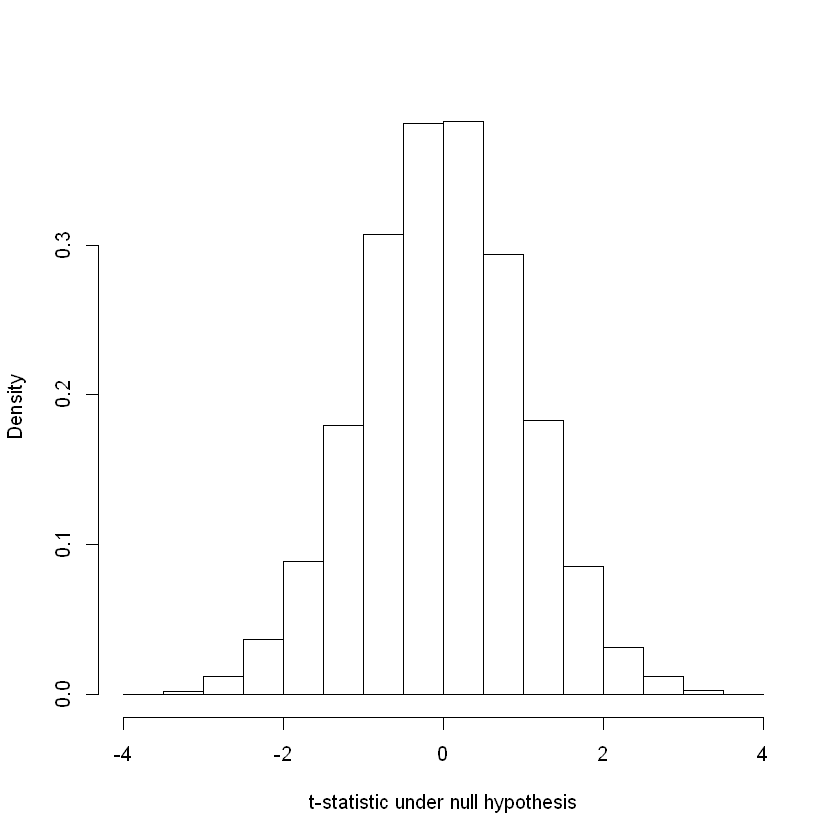

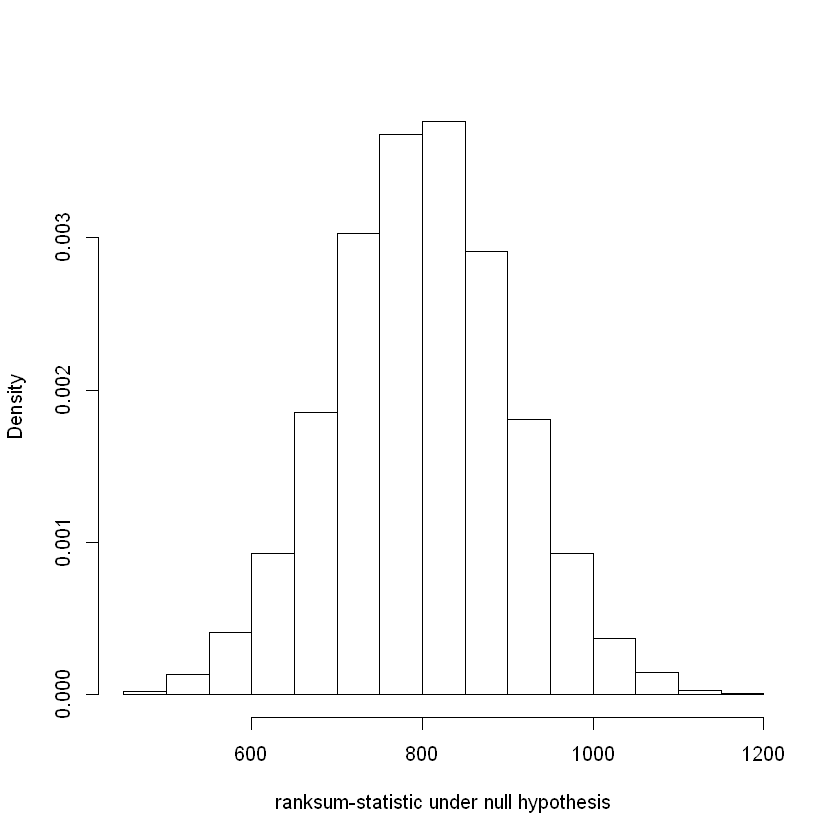

In [45]:
hist(distr.t.stat.null, prob = T, main = "", 
     xlab = "t-statistic under null hypothesis")
hist(distr.ranksum.stat.null, prob = T, main = "", 
     xlab = "ranksum-statistic under null hypothesis")

From here, we can approximate what the cutoff statistic should be so that the tail probability to the right of the cutoff would be 0.05.  In other words, this is a hypothetical observed test statistic that would produce a p-value of exactly 0.05 in a one-sided "greater than" test.

In [46]:
cutoff.t <- quantile(distr.t.stat.null, 0.95)[[1]]
cutoff.ranksum <- quantile(distr.ranksum.stat.null, 0.95)[[1]]
round(cutoff.t, 2)
cutoff.ranksum

[1] 1.67

[1] 972

In other words, if we had gotten a dataset with a t-statistic above 1.67, it would have produced a p-value below 0.05.  If we had gotten a ranksum statistic above 972, it would have also produced a p-value below 0.05.

Now we can simulate the distribution of these statistics under the *particular* alternative probability model that the difference in means (and medians) between the distributions is 1.  From this, we can guage how likely it would have been under this alternative to observe a t-statistic above 1.67 or a ranksum-statistic above 972, since this is what would have been necessary for us to reject the null hypothesis.

In [47]:
distr.t.stat.alt <- numeric(B)
distr.ranksum.stat.alt <- numeric(B)
for (i in 1:B) {
    y1 <- rnorm(40, mean = 1, sd = 2)
    y2 <- rnorm(40, mean = 0, sd = 2)
    # i'm using the test functions below just to calculate the test statistic easily
    # not to perform an actual test
    distr.t.stat.alt[i] <- t.test(y1, y2, var.equal = TRUE)$statistic
    distr.ranksum.stat.alt[i] <- wilcox.test(y1, y2, exact = TRUE)$statistic
}

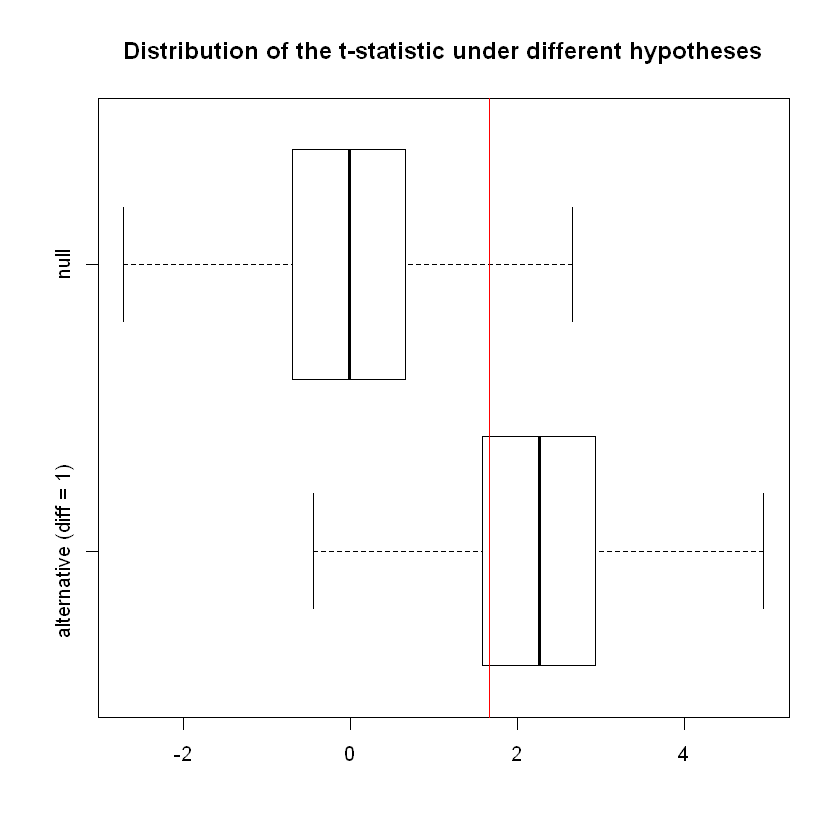

In [48]:
boxplot(list("alternative (diff = 1)" = distr.t.stat.alt, "null" = distr.t.stat.null), 
        outline = F, horizontal = T, 
        main = "Distribution of the t-statistic under different hypotheses")
abline(v = cutoff.t, col = 'red')

Using the cutoff of 1.67 we earlier established, we can visually see that while there is only 5% of the distribution to the right of this cutoff in the null (by definition).  Under the alternative, there is just under 75% of of the distribution that is to the right of the cutoff.  We can approximate this value more closely as follows:

In [49]:
power.t <- mean(distr.t.stat.alt >= cutoff.t)
round(power.t, 3)

[1] 0.721

This means that if this particular null hypothesis were true, there would be a 72.1% chance that we would receive a dataset  where we would correctly reject the null hypothesis in favor of the one-sided alternative we discussed.  Let's repeat the same analyis with the ranksum test.

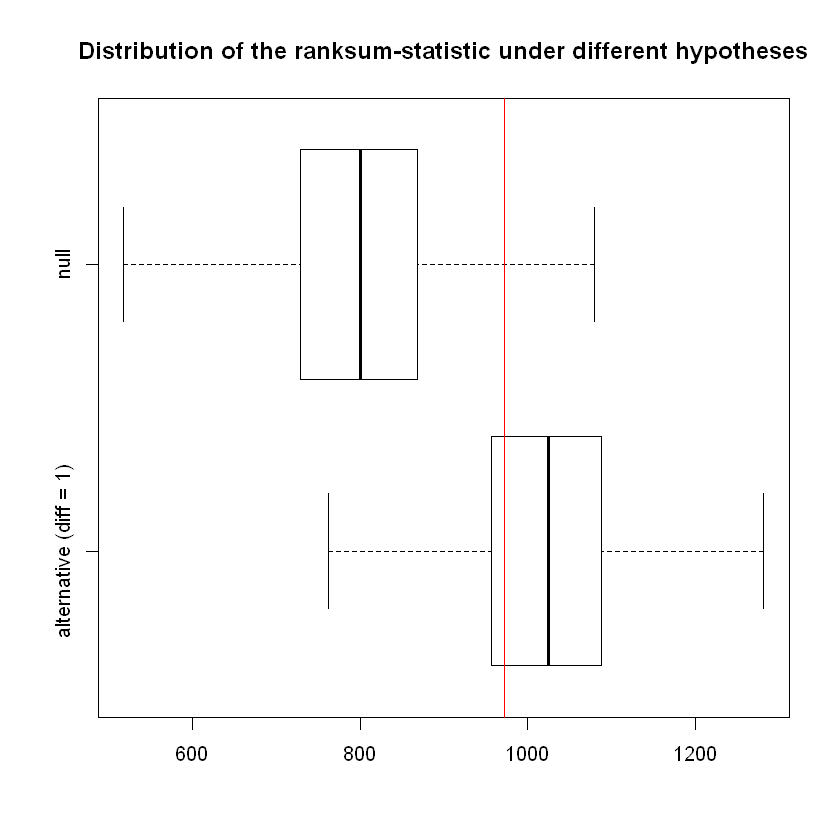

In [50]:
boxplot(list("alternative (diff = 1)" = distr.ranksum.stat.alt, "null" = distr.ranksum.stat.null), 
        outline = F, horizontal = T, 
        main = "Distribution of the ranksum-statistic under different hypotheses")
abline(v = cutoff.ranksum, col = 'red')

In [51]:
power.ranksum <- mean(distr.ranksum.stat.alt >= cutoff.ranksum)
round(power.ranksum, 3)

[1] 0.704

The rank sum has a power of 70.4%, which is about 2% lower than the t-test for this problem.  This may seem pretty miniscule, but the the power differences between tests can be quite stark in some cases.  Furthermore, you want to give yourself the best chance possible to discover something interesting about your data!  When the normality and equal variances assumptions hold, you can prove that you need just over 5% more data with the rank sum test to make the same conclusion that you would have made with Student's t-test.

Your sample size affects your power.  Let's quickly repeat the above analysis for the t-test, but now with triple the sample size.

In [52]:
### Approximate cutoff from null distribution
distr.t.stat.null <- numeric(B)
for (i in 1:B) {
    y1 <- rnorm(120, mean = 0, sd = 2)
    y2 <- rnorm(120, mean = 0, sd = 2)
    # i'm using the test functions below just to calculate the test statistic easily
    # not to perform an actual test
    distr.t.stat.null[i] <- t.test(y1, y2, var.equal = TRUE)$statistic
}
cutoff.t <- quantile(distr.t.stat.null, 0.95)[[1]]

# calculate power from alternative distribution
distr.t.stat.alt <- numeric(B)
for (i in 1:B) {
    y1 <- rnorm(120, mean = 1, sd = 2)
    y2 <- rnorm(120, mean = 0, sd = 2)
    # i'm using the test functions below just to calculate the test statistic easily
    # not to perform an actual test
    distr.t.stat.alt[i] <- t.test(y1, y2, var.equal = TRUE)$statistic
}
power.t <- mean(distr.t.stat.alt >= cutoff.t)
round(power.t, 3)

[1] 0.987

If this alternative is true, we now have a 98.7% chance of rejecting the null! Increasing your sample size increases your power. 

## Power Analysis

This sort of observation leads to what's known as power analysis, which answers the question of: how should you choose when to stop collecting data in your data gathering procedure?  Collecting data is expensive and invasive in medicine, so we would ideally like to find the smallest sample size that can answer a scientifically meaningful question.  As a more concrete example, how many patients should you enroll in a randomized clinical trial such that the t-test for a continuous outcome has a power of at least 80%?


Here are the steps to peform a power analysis:

1. Pick what sort of hypothesis test you're going to perform in your analysis.  You should usually have some sense of what your data might look like, what it's shape might be, and what assumptions might be valid.  

2. Choose the minimum true effect size that you would consider "clinically meaningful".  This determines your particular alternative probability model (or a collection of them with the same power).

3. Calculate the power of these alternative probability models for a grid of different sample sizes.

4. Choose a minimum desired power level (determined apriori and arbitrarily).  The minimum sample size whose power exceeds this cutoff is the sample size you pick for your study. Optionally, inflate this number by a small percentage like 10-20%.  


Somtimes, we can do step 3 pretty cleanly with mathematics, and there exist functions to do this for you.  However, brute-forcing the solution via simulation is usually a viable and flexible option.

# Issues in Testing

## Multiple-Testing

Suppose I have data on heart failure status and 200 drug exposures.  I am interested in discovering if there is an association between any of these drugs and heart failure.  Suppose further that the null hypothesis is actually true for all 200 of these associations.  How many times will I wrongly reject the null on average?  If you recall from the beginning of the session, p-values are uniformly distributed between 0 and 1 under the null hypothesis.  Thus, I would expect about 5% of my 200 tests to be false positives; in other words, I'd expect to reject 10 null hypotheses, all incorrectly.

This is less than ideal.  The null hypothesis framework for a single test ensures that, under the null hypothesis, there is a 5% chance of making a Type-1 error.  Statisticians have extended the null-hypothesis framework in two directions to counter this problem with performing multiple hypothesis tests simultaneously.  Operationally, they consist of calculating each of your p-values as usual and then handing them over to some multiple-testing procedure (algorithm) that tells you whether to reject or accept the null for each one.

### Controlling the Family-Wise Error Rate (FWER)

Controlling FWER is a conceptually straightforward extension.  If we have multiple tests, why don't we just ensure there's a 5% chance of making *any* Type-1 error across all tests under consideration. 

Everyone and their mother will tell you to use the **Bonferroni Procedure** to accomplish this.  However, what they don't realize is that Bonferroni is really just a teaching tool to provide a very simple strategy that technically accomplishes this goal.  It makes the FWER way smaller than 5% and causes you to drastically lose power by its stupid simplicity.  Ask your local statistician for better options, but an acceptable place to start is the **Holm-Bonferroni Procedure**.

Typical situations where you want to control the FWER is when you have a small handful of hypotheses, and it is imperative that any "discoveries" (read: rejecting null hypotheses) represent real scientific truths.  An example might be when you perform a study with 3-8 primary and secondary clinical endpoints that were decided apriori in a pre-analysis plan.

### Controlling the **False Discovery Rate (FDR)**

When reading/thinking about FDR, the word discovery == rejected null hypothesis.  When you try to control the FDR, you say - look, I know I'm going to have some false positives.  That's okay.  What I really care about is controlling the (expected) proportion of false positives out of all my discoveries (false positives + true positives).  That expected proportion is the FDR.

An acceptable procedure to first consider would be the **Benjamini-Hochberg Procedure**, but you should check with your local statistician if this is appropriate and what your alternatives might be.

Typical situations where you want to control the FDR is when you are testing lots and lots of things and looking to generate some potential scientific questions for future studies.  The 200 drugs example we started with is a perfect example of this.  Another is genome association studies, where you have 10,000 genes and you're trying to find a small subset that could be associated with a phenotype or disease. 

## p-Hacking

p-hacking is an ever-pervasive, unscientific, and undying habit of nearly all fields.  It is the art of artificially making your p-values look small.  p-hacking is not always malicious and intentional, and it can inadventently be influenced by any part of your data analysis including the exploratory phase.  

Fighting against the culture of p-hacking is an important endeavor.  You must try to prevent yourself from doing it in egregious ways. However, a certain small amount of p-hacking is actually always inevitable; it's like assumptions - small violations are probably fine. In your scientific career, you are likely to experience a well-respected researcher more senior than you ask you to do something (intentially or unintentionally) that would constitute egregious p-hacking at least once.  Recognizing p-hacking and bringing it to their attention with diplomatic phrasing is another important skill.

p-hacking starts all the way at sample selection.  Tailoring your sample to hone in on a narrow research question is good science.  Tailoring your sample simply to amplify an effect size is p-hacking.  Not including the full breakdown of how your analysis sample was constructed could also be p-hacking.  For example, if you did full-case analysis (i.e. you dropped patients with missing data) but you didn't communicate this, this could be p-hacking.  Those dropped patients could have been healthier on average and had a smaller effect size, and their presence would have inflated your p-value.  If you communicate this, and it is scientifically reasonable, then this step is okay. Modifying your inclusion criteria in general after looking at your data is p-hacking. Running your analysis with and without outliers and picking the better results is obviously p-hacking.

p-hacking continues into exploratory data analysis.  If you choose what to test based on your visualizations, this is p-hacking.  Some transformations we perform after looking at the data constitute a very mild form of p-hacking; an example is the log transformation we used on white blood cell count.  You can think of this as removing one degree of freedom, but I wanted to highlight this as an example that is "technically p-hacking a little" but probably acceptable due to its minimal impact.

p-hacking takes place at all stages of the actual analysis.  Favorable imputation for missing data is obviously p-hacking. Incomplete reporting of all the tests you ran on your outcomes (only displaying signficiant results) is p-hacking.  Doing many subgroup analyses and picking the significant ones is p-hacking.  Adding or removing independent variables from your regression analyses (we'll cover this in the next session) until the results look good is p-hacking.  Trying out different tests on the same problem and seeing which ones give you the best results is p-hacking.

There are many examples that I haven't covered here.  Almost all p-hacking can be thought of as implicit or explicit multiple testing without reporting or accounting for the multiple testing.  For example, lets say you only formally tested the variables that looked correlated in your exploratory data analysis.  When you did your exploratory data analysis, your interpretation that the plots looked correlated was a weak form of implicit testing.  If you looked at 100 pairs of variables, but only formally test 5 pairs based on your visual analysis and report that, then you failed to account for the implicit multiple testing you performed on the 100 pairs.

In general, there are two solutions.

1. Have a pre-analysis plan.  Specify what your analysis and approach is going to be before you get the data and follow through with your plan.  This prevents the constant loop of looking at your data and adjusting your methods, which constitutes most p-hacking.

2. Be clear about and report all the various associations you explored.  Use formal multiple testing procedures to account for this.